# AirBnB Rentals in NYC 
In this project, I have taken data from Kaggle on Airbnb listings in NYC. Here I start by doing some exploratory data analysis, after which I will try to predict property prices based on selected features. 


- link to data: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data
- link to reviews data: http://insideairbnb.com/get-the-data.html

In [1]:
#import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from langdetect import detect
from textblob import TextBlob, Word
from googletrans import Translator
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
#import the data
path_1 = r'./Data/AB_NYC_2019.csv'
listings_data = pd.read_csv(path_1)

### Overall Data Checks

In [3]:
#check how many rows and columns there are
listings_data.shape

(48895, 16)

In [4]:
# look at the column names
listings_data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [5]:
# check the data (each row represents one property)
listings_data.head(5)

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [6]:
listings_data.dtypes
# Here we can see the id's are integers, we may want to convert them to objects/strings when doing any visualisations as they 
#should be treated as categorical variables rather than numerical 

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [7]:
listings_data['id'] = listings_data['id'].apply(str)
listings_data['host_id'] = listings_data['host_id'].apply(str)

In [8]:
listings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  object 
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  object 
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [9]:
#check for null values as we can see there are a few nulls looking at the info output from above
listings_data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

It looks like some of the reviews columns have a lot of null values, maybe for properties which don't have any reviews. I will leave these rows in for now and remove them later if needed. Some property names are also null; I will only remove these if I need to use the property names later but since I should be able to use the `id`, I won't remove them for now. 

In [10]:
listings_data[listings_data.host_name.isnull()].host_id.value_counts()

159156636    3
32722063     2
415290       1
228750026    1
177146433    1
23077718     1
919218       1
5300585      1
26138712     1
119609345    1
7779204      1
24576978     1
7822683      1
526653       1
5162530      1
33134899     1
100971588    1
39608626     1
Name: host_id, dtype: int64

The majority of null host names only appear null once. There is one that appears null 3 times; we can take a deeper look to see if the name appears at any time in the full dataset. Otherwise, maybe they wish to stay anonymous in which case we can use the host id instead of the host names as there are no null host id's.

In [11]:
#filter the dataset to see if host 159156636's name ever appears. If so, we can replace the nulls with his actual name. If
#not, we will just use the host id to do any aggregations
listings_data[listings_data.host_id=='159156636']

id                                               name    host_id  \
27962  21867710  Amazing room in the centre on Manhatten! Welcome!  159156636   
28042  21901156  Best Deal! Lovely place in Manhattan! Time Squ...  159156636   
28274  21990808                 ***SLEEPING IN THE GOLDEN PLACE***  159156636   

      host_name neighbourhood_group   neighbourhood  latitude  longitude  \
27962       NaN           Manhattan  Hell's Kitchen  40.75668  -73.99097   
28042       NaN           Manhattan  Hell's Kitchen  40.75656  -73.99063   
28274       NaN           Manhattan  Hell's Kitchen  40.75835  -73.99065   

          room_type  price  minimum_nights  number_of_reviews last_review  \
27962  Private room    120               1                 89  2019-01-01   
28042  Private room    120               1                109  2019-01-01   
28274  Private room    120               1                 88  2018-12-14   

       reviews_per_month  calculated_host_listings_count  availability_365  
27962               5.16                               3                 0  
28042               5.97                               3                 0  
28274               4.93                               3                 0

This host's name remains unknown; we can use host id if ever needed. Also, their listings all seem to be within the same neighbourhood and could possibly even be part of the same building/street (longitude values look very similar but are not identical) 

In [12]:
# look at descriptive stats for all columns
listings_data.describe().T

count        mean         std       min  \
latitude                        48895.0   40.728949    0.054530  40.49979   
longitude                       48895.0  -73.952170    0.046157 -74.24442   
price                           48895.0  152.720687  240.154170   0.00000   
minimum_nights                  48895.0    7.029962   20.510550   1.00000   
number_of_reviews               48895.0   23.274466   44.550582   0.00000   
reviews_per_month               38843.0    1.373221    1.680442   0.01000   
calculated_host_listings_count  48895.0    7.143982   32.952519   1.00000   
availability_365                48895.0  112.781327  131.622289   0.00000   

                                     25%        50%         75%          max  
latitude                        40.69010   40.72307   40.763115     40.91306  
longitude                      -73.98307  -73.95568  -73.936275    -73.71299  
price                           69.00000  106.00000  175.000000  10000.00000  
minimum_nights                   1.00000    3.00000    5.000000   1250.00000  
number_of_reviews                1.00000    5.00000   24.000000    629.00000  
reviews_per_month                0.19000    0.72000    2.020000     58.50000  
calculated_host_listings_count   1.00000    1.00000    2.000000    327.00000  
availability_365                 0.00000   45.00000  227.000000    365.00000

`Price`: The average price is `$152` per night, however we can see there are some that are priced at `$10000` per night! 

`Min nights`: It looks like there is a strange value of 1250 nights needed for some properties, we will look at this and remove it if there aren't too many of these values. Otherwise, 7 nights on average seems reasonable. 

`Calculated host listings count`: On average, hosts seem to have 7 properties listed. It looks like there is one or more with 327 properties! It may be a company but we can also look into this further later. 

### Exploratory Data Analysis

Text(0.5, 0, 'Neighbourhood Group')

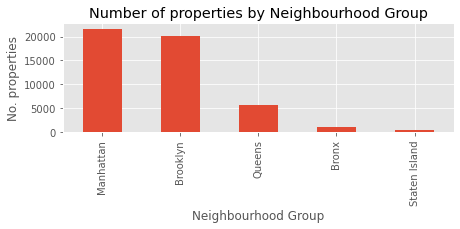

In [13]:
#Plot the number of properties within each neighbourhood group

plt.style.use('ggplot')
plt.figure(figsize=(7,2))
listings_data.neighbourhood_group.value_counts().plot(kind = "bar")
plt.title("Number of properties by Neighbourhood Group")
plt.ylabel("No. properties")
plt.xlabel("Neighbourhood Group")

Here it looks like the majority of properties are in Manhattan, followed by Brooklyn and Queens. Bronx and Staten Island seem to have a low number of properties but I will check the actual values below. 

In [14]:
listings_data.neighbourhood_group.value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

It looks like I may only get valuable insights from the top 3 neighbourhood groups, but I will leave them all in for now and remove only if necessary. I will now check the average price of rentals by neighbourhood group

In [15]:
print("The average price of a rental in NYC is {}".format(np.mean(listings_data.price)))
listings_data.groupby('neighbourhood_group').price.describe()

The average price of a rental in NYC is 152.7206871868289


count        mean         std   min   25%    50%  \
neighbourhood_group                                                       
Bronx                 1091.0   87.496792  106.709349   0.0  45.0   65.0   
Brooklyn             20104.0  124.383207  186.873538   0.0  60.0   90.0   
Manhattan            21661.0  196.875814  291.383183   0.0  95.0  150.0   
Queens                5666.0   99.517649  167.102155  10.0  50.0   75.0   
Staten Island          373.0  114.812332  277.620403  13.0  50.0   75.0   

                       75%      max  
neighbourhood_group                  
Bronx                 99.0   2500.0  
Brooklyn             150.0  10000.0  
Manhattan            220.0  10000.0  
Queens               110.0  10000.0  
Staten Island        110.0   5000.0

On average, Manhattam looks like it has the most expensive rentals, followed by Brooklyn and then Staten Island. Let's also take a look at the boxplots to see the range of prices within the areas 

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

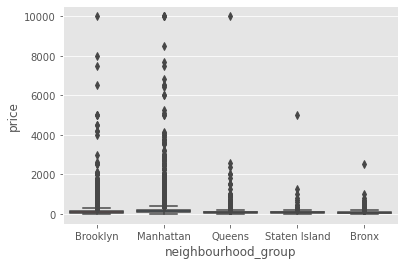

In [16]:
sns.boxplot(x=listings_data.neighbourhood_group, y=listings_data.price)

Looks like there are some very expensive properties in Brooklyn and Manhattan!! I'll also have a look at the IQR only to get a good idea of where the majority of properties lie

Text(0.5, 1.0, 'Rental prices by neighbourhood group')

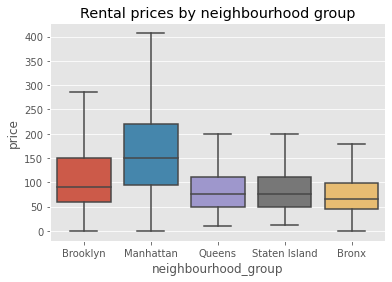

In [17]:
sns.boxplot(x=listings_data.neighbourhood_group, y=listings_data.price,showfliers=False)
plt.title("Rental prices by neighbourhood group")

Again, we can see that Manhattan has the priciest rentals, but the Manhattan pricing also has a larger range in comparison to the other areas. We can also see here that there are some properties in Brooklyn & Manhattan with a price of 0, so let's see what those properties are and remove them (it's highly unlikely someone would rent a property free of charge!!) 

In [18]:
#check how many listings have a price of 0 
listings_data[listings_data.price == 0].shape

(11, 16)

In [19]:
listings_data[listings_data.price == 0].head(5)

id                                               name    host_id  \
23161  18750597  Huge Brooklyn Brownstone Living, Close to it all.    8993084   
25433  20333471      ★Hostel Style Room | Ideal Traveling Buddies★  131697576   
25634  20523843    MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)   15787004   
25753  20608117                    Sunny, Quiet Room in Greenpoint    1641537   
25778  20624541      Modern apartment in the heart of Williamsburg   10132166   

          host_name neighbourhood_group       neighbourhood  latitude  \
23161      Kimberly            Brooklyn  Bedford-Stuyvesant  40.69023   
25433        Anisha               Bronx     East Morrisania  40.83296   
25634  Martial Loft            Brooklyn            Bushwick  40.69467   
25753        Lauren            Brooklyn          Greenpoint  40.72462   
25778       Aymeric            Brooklyn        Williamsburg  40.70838   

       longitude        room_type  price  minimum_nights  number_of_reviews  \
23161  -73.95428     Private room      0               4                  1   
25433  -73.88668     Private room      0               2                 55   
25634  -73.92433     Private room      0               2                 16   
25753  -73.94072     Private room      0               2                 12   
25778  -73.94645  Entire home/apt      0               5                  3   

      last_review  reviews_per_month  calculated_host_listings_count  \
23161  2018-01-06               0.05                               4   
25433  2019-06-24               2.56                               4   
25634  2019-05-18               0.71                               5   
25753  2017-10-27               0.53                               2   
25778  2018-01-02               0.15                               1   

       availability_365  
23161                28  
25433               127  
25634                 0  
25753                 0  
25778                73

They look like legitimate properties and also have reviews, so it's unlikely they're new. Since there are only 11 we'll remove these. 

In [20]:
#take only listings with price > 0
listings_data = listings_data[listings_data.price > 0]

Text(0.5, 0, 'Price per night')

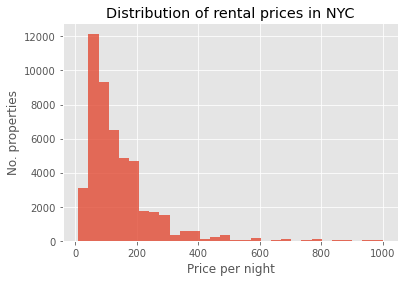

In [21]:
#Look at the distribution of prices for properties less than $1000 per night
listings_data[listings_data.price < 1000].price.hist(bins = 30, alpha = 0.8)
plt.title("Distribution of rental prices in NYC")
plt.ylabel("No. properties")
plt.xlabel("Price per night")

Here we can see the majority of properties are less than `$1000` per night. So the others (> `$1000`) are extreme values. Within this smaller range, the majority look to be around `$75-$100` per night. 

Text(0.5, 0, 'Room type')

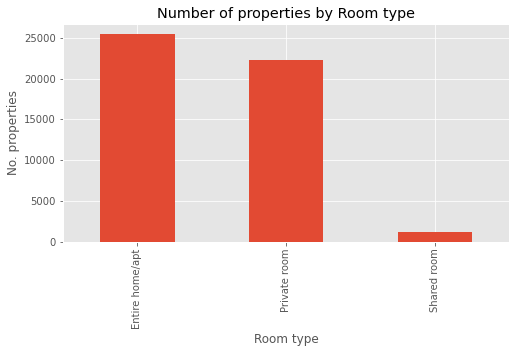

In [22]:
# plot the number of properties by room type 

plt.style.use('ggplot')
plt.figure(figsize=(8,4))
listings_data.room_type.value_counts().plot(kind = "bar")
plt.title("Number of properties by Room type")
plt.ylabel("No. properties")
plt.xlabel("Room type")

The majority of properties are entire homes/apartments, followed by private rooms. Let's see if the pricing is different depending on the room type

Text(0.5, 0, 'Room type')

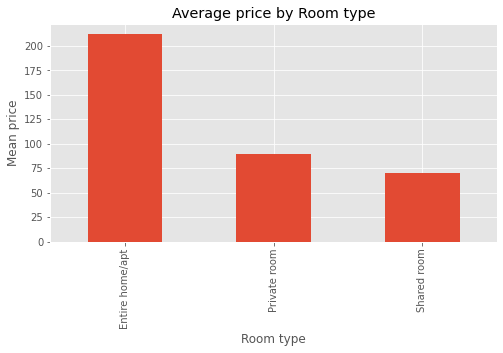

In [23]:
# plot the average price by room type
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
listings_data.groupby('room_type').price.mean().plot(kind = "bar")
plt.title("Average price by Room type")
plt.ylabel("Mean price")
plt.xlabel("Room type")

It looks like entire homes are the most expensive on average, followed by private rooms. 

Text(0.5, 1.0, 'Rental prices by room type')

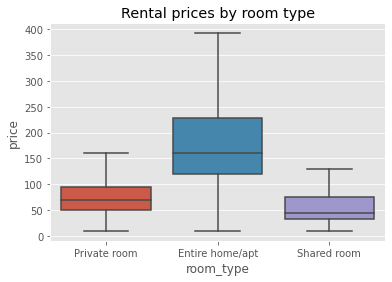

In [24]:
#plot a boxplot (without extreme values so it's easier to interpret - we already know there will be loads of outliers)
sns.boxplot(x=listings_data.room_type, y=listings_data.price,showfliers=False)
plt.title("Rental prices by room type")

In [25]:
#look at the mean price by room type
listings_data.groupby('room_type').price.mean()

room_type
Entire home/apt    211.810918
Private room        89.809131
Shared room         70.248705
Name: price, dtype: float64

Now, let's look at the relationships between price and other columns in our dataset 

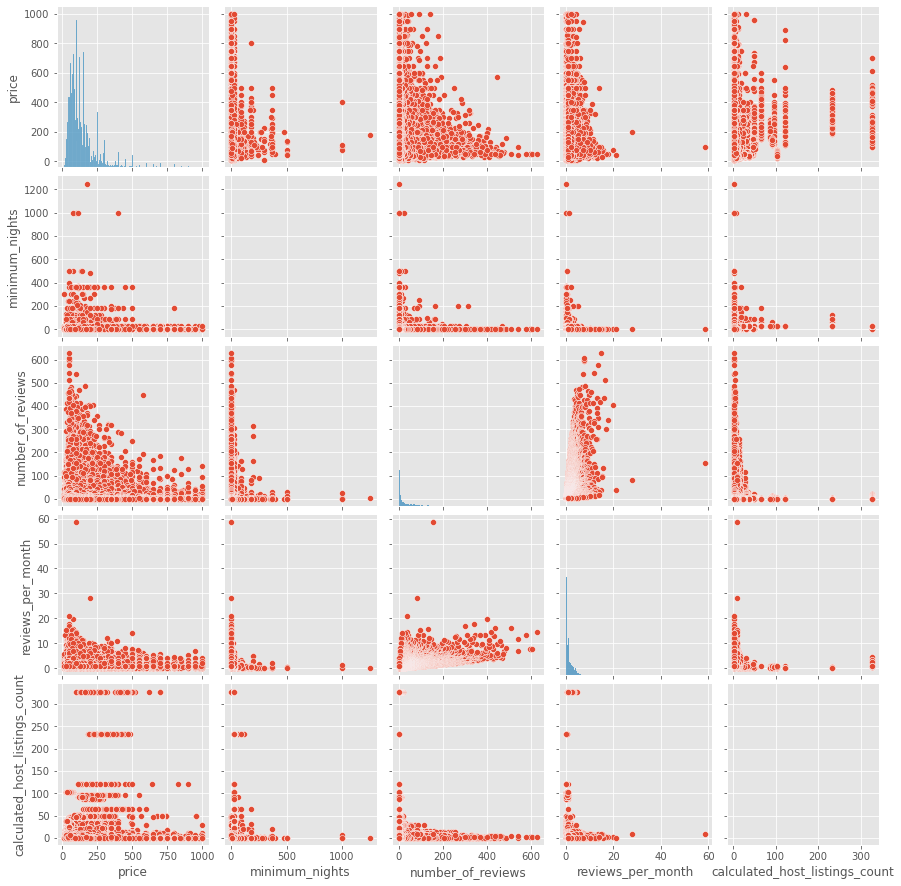

In [26]:
#plot a pairplot on a selected few columns of interest to see if there is any obvious relationship
# here I have filtered on properties priced at < 1000 per night as it was difficult to see any relationships in the full dataset 
selected_cols = ['price', 'minimum_nights', 'neighbourhood_group',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count']
sns.pairplot(listings_data[listings_data.price < 1000][selected_cols])

It looks like there is a negative correlation between the number of reviews and the price per night. It could be that the most expensive rentals are very exclusive and may not get a lot of stays, which leads to less reviews over time. They could also be newer properties which haven't had the time to accumulate as many reviews as properties that have been listed on Airbnb for longer. 

Since we have a LOT of data, it's hard to tell if there are any other obvious relationships using the pairplot above. But we can check the relationship between reviews per month and price with an lmplot

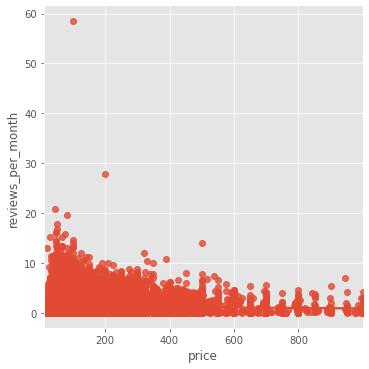

In [27]:
sns.lmplot(x="price", y="reviews_per_month", data = listings_data[listings_data.price < 1000])

There seems to be a negative correlation, but it's difficult to tell with an lmplot. I can visualise the correlations slightly better with a `heatmap`

<AxesSubplot:>

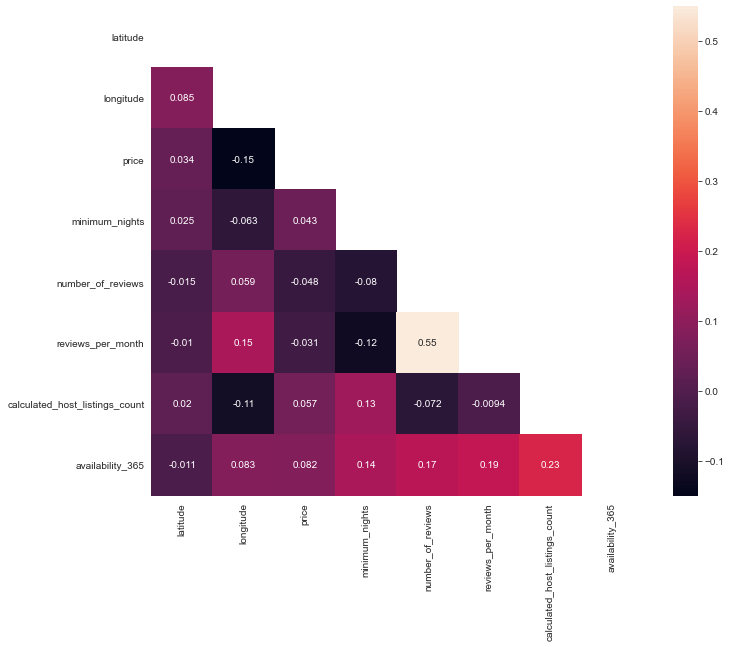

In [28]:
correlations = listings_data.corr()

# Exclude duplicate correlations by masking uper right values
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set background color / chart style
sns.set_style(style = 'white')

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(correlations, mask = mask, annot=True)

The majority of these seem to be neutral in relation to `price`. We can see that `number_of_reviews` and `reviews_per_month` are highly correlated as expected, since one is a function of the other. Also, `calculated_host_listings_count` is positively correlated with `availability_365`, indicating that properties owned by hosts with more properties are more likely to have upcoming availabilty. `availability_365` is also positively correlated with `reviews_per_month`, which indicates listings which have more availability are likely to have more reviews listed per month. 

#### Looking at the hosts 

Text(0.5, 0, 'Host id')

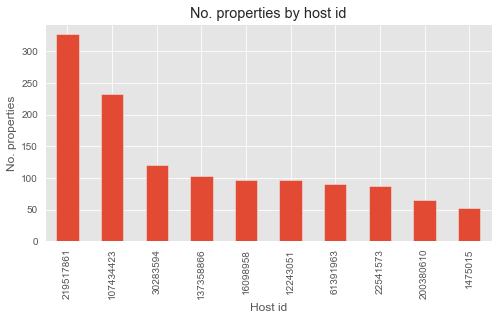

In [29]:
# Looking at the no. properties by the hosts with the top 10 
# I could have used the calculated host listings count instead, but this should give the same result anyway
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
listings_data.host_id.value_counts()[:10].plot(kind = "bar")
plt.title("No. properties by host id")
plt.ylabel("No. properties")
plt.xlabel("Host id")

In [30]:
print(listings_data.host_id.value_counts()[:1])

219517861    327
Name: host_id, dtype: int64


Looks like host `219517861` has 327 properties, however we do have a few hosts with a large number of properties listed. 

In [31]:
listings_data[listings_data['host_id']== '219517861'].head()

id                                           name    host_id  \
38293  30181691  Sonder | 180 Water | Incredible 2BR + Rooftop  219517861   
38294  30181945     Sonder | 180 Water | Premier 1BR + Rooftop  219517861   
38588  30347708    Sonder | 180 Water | Charming 1BR + Rooftop  219517861   
39769  30937590        Sonder | The Nash | Artsy 1BR + Rooftop  219517861   
39770  30937591    Sonder | The Nash | Lovely Studio + Rooftop  219517861   

          host_name neighbourhood_group       neighbourhood  latitude  \
38293  Sonder (NYC)           Manhattan  Financial District  40.70637   
38294  Sonder (NYC)           Manhattan  Financial District  40.70771   
38588  Sonder (NYC)           Manhattan  Financial District  40.70743   
39769  Sonder (NYC)           Manhattan         Murray Hill  40.74792   
39770  Sonder (NYC)           Manhattan         Murray Hill  40.74771   

       longitude        room_type  price  minimum_nights  number_of_reviews  \
38293  -74.00645  Entire home/apt    302              29                  0   
38294  -74.00641  Entire home/apt    229              29                  1   
38588  -74.00443  Entire home/apt    232              29                  1   
39769  -73.97614  Entire home/apt    262               2                  8   
39770  -73.97528  Entire home/apt    255               2                 14   

      last_review  reviews_per_month  calculated_host_listings_count  \
38293         NaN                NaN                             327   
38294  2019-05-29               0.73                             327   
38588  2019-05-21               0.60                             327   
39769  2019-06-09               1.86                             327   
39770  2019-06-10               2.59                             327   

       availability_365  
38293               309  
38294               219  
38588               159  
39769                91  
39770                81

Sonder looks like it is a company name, it also looks like they have their own website! 

#### Looking at the min. nights requirement

Text(0.5, 0, 'Min nights required to book')

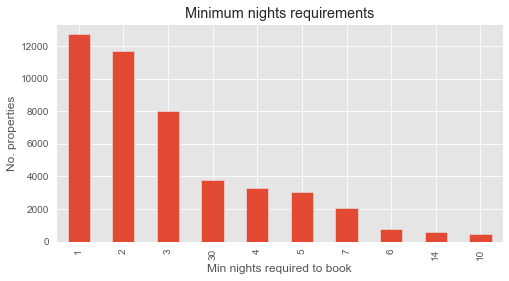

In [32]:
# plot the number of properties per min_nights required
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
listings_data.minimum_nights.value_counts()[:10].plot(kind = "bar")
plt.title("Minimum nights requirements")
plt.ylabel("No. properties")
plt.xlabel("Min nights required to book")

It looks like the majority require 1 night minimum stay. There are around 4000 properties that require 30 nights (long term stays) otherwise the majority are for short term stays

<AxesSubplot:xlabel='neighbourhood_group', ylabel='minimum_nights'>

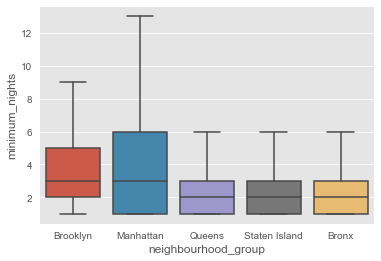

In [33]:
#plot min nights by neighbourhood group to see if there are any differences
sns.boxplot(x=listings_data.neighbourhood_group, y=listings_data.minimum_nights, showfliers = False)

It looks like Manhattan offers a range of listings with varied minumum nights requirements. 

<AxesSubplot:>

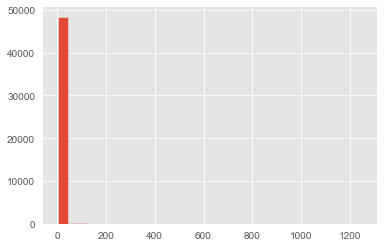

In [34]:
listings_data.minimum_nights.hist(bins=30)

Strange that there are properties with minimum stay requirements exceeding 1 month. It looks like there are only a few of these in comparison to the majority so we will remove them. 

In [35]:
listings_data[listings_data.minimum_nights > 30].shape

(747, 16)

In [36]:
#exclude rentals with a minimum nights requirement exceeding 30 days
listings_data = listings_data[listings_data.minimum_nights <= 30]

In [37]:
# check how many rentals are left
listings_data.shape

(48137, 16)

Text(0.5, 0, 'Min. nights')

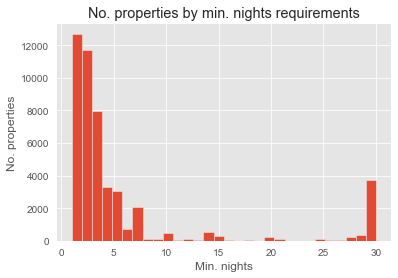

In [38]:
listings_data[listings_data.minimum_nights <= 30].minimum_nights.hist(bins=30)
plt.title("No. properties by min. nights requirements")
plt.ylabel("No. properties")
plt.xlabel("Min. nights")

Now we can also see there are properties with a 7 or 14 night stay requirement, as well as a few with 21 days. We may be able to group these up into short stay vs long stay properties when doing feature engineering. (Or even < 1 week, 1-4 weeks and 4 weeks+). We can also see a peak at 30 days, showing that the 30 day requirement may be an important feature to consider

### Geographical Data Viz

Before plotting the price range on a map, I want to transform my price data as it is heavily right-skewed. I'll take a log of the data to start with 

In [39]:
listings_data['log_price'] = np.log(listings_data.price)

Text(0.5, 6.799999999999994, 'Price per night (log)')

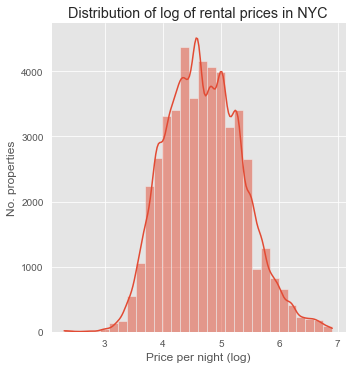

In [40]:
#Look at the distribution of log prices for properties less than $1000 per night

sns.displot(listings_data[listings_data.price <1000].log_price, kde=True, bins = 30, kind="hist")

plt.title("Distribution of log of rental prices in NYC")
plt.ylabel("No. properties")
plt.xlabel("Price per night (log)")


I'm much happier with this distribution as it now the density distribution is much closer to a normal distribution. This will help me plot more meaningful distributions than the original which is heavily skewed. I will now use this log price to view the distribution on a map of NYC.

Text(0.5, 1.0, 'Geographic visualisation of (log) rental prices in NYC')

<Figure size 504x504 with 0 Axes>

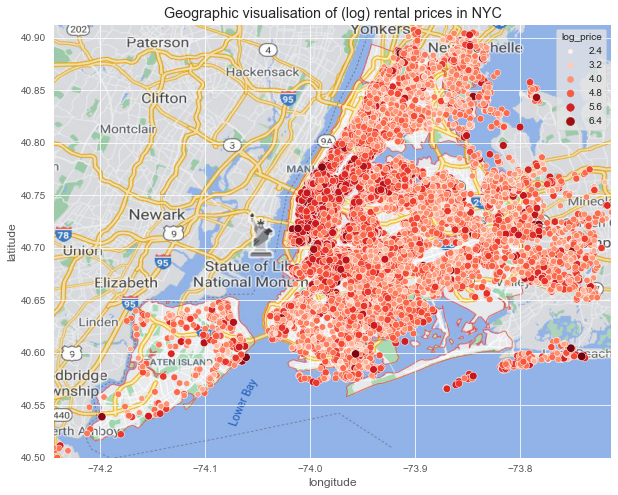

In [41]:
# plot log price against long/lat coordinates

plt.figure(figsize=(7,7))
#import map image
img=plt.imread('C:/Users/hmalek/Documents/General_Assembly/projects/project-final/Data/NYC 2.JPG',0)

# Graph size
plt.figure(figsize=(10,10))

# Graph and image settings
plt.imshow(img, zorder=0, extent=[listings_data['longitude'].min(),listings_data['longitude'].max(),
                                listings_data['latitude'].min(),listings_data['latitude'].max()])

# When an image is included, use it.
ax = plt.gca()

#plot a scatterplot of the properties with the hue reflecting log price
palette = sns.color_palette("Reds", as_cmap=True)

sns.scatterplot(x="longitude", y="latitude", hue = "log_price", data = listings_data[listings_data.price < 1000], 
                palette= palette, size="log_price")

plt.title("Geographic visualisation of (log) rental prices in NYC")


Here we can see the expensive rentals are clustered around the lower Manhattan area, with a couple of exceptions in Staten Island and Queens. 

<AxesSubplot:xlabel='price', ylabel='log_price'>

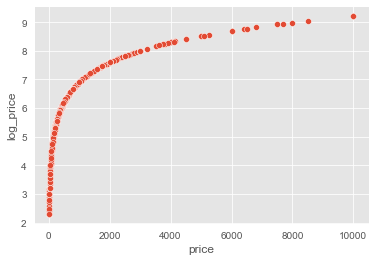

In [42]:
#plot price against log price for a rough idea of what the log values correspond to 
sns.scatterplot(x="price", y= "log_price", data = listings_data)

We can also visualise the availability over the next 365 days, but it's difficult to see many clusters here. It looks as though there may be clusters of white dots (little to no availability) around the Manhattan and Brooklyn areas which may indicate their popularity, however we can't say this with certainty as maybe the hosts don't rent out their properties all year round either! 

Text(0.5, 1.0, 'Geographic visualisation of rental availability in NYC')

<Figure size 504x504 with 0 Axes>

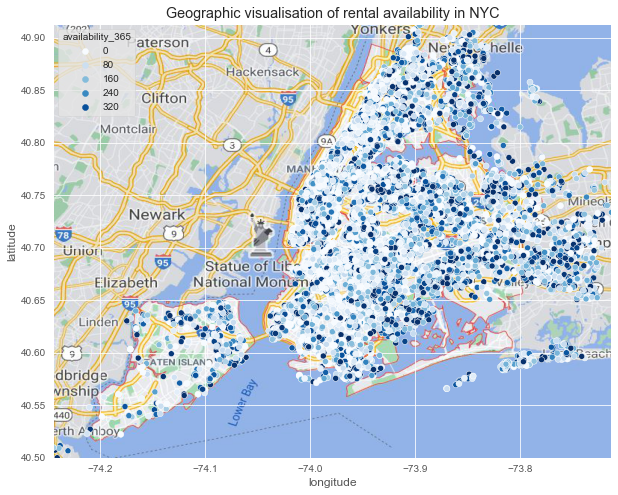

In [43]:
#plot rental availability against long/lat coordinates

plt.figure(figsize=(7,7))
#import map image
img=plt.imread('C:/Users/hmalek/Documents/General_Assembly/projects/project-final/Data/NYC 2.JPG',0)

# Graph size
plt.figure(figsize=(10,10))

# Graph and image settings
plt.imshow(img, zorder=0, extent=[listings_data['longitude'].min(),listings_data['longitude'].max(),
                                listings_data['latitude'].min(),listings_data['latitude'].max()])

# When an image is included, use it.
ax = plt.gca()

#plot a scatterplot of the properties with the hue reflecting log price
palette = sns.color_palette("Blues", as_cmap=True)

sns.scatterplot(x="longitude", y="latitude", hue = "availability_365", data = listings_data[listings_data.price < 1000], 
                palette= palette)

plt.title("Geographic visualisation of rental availability in NYC")

## Reviews data

In [44]:
#read in reviews data
path_2 = r'./Data/reviews.csv'

In [45]:
reviews_data = pd.read_csv(path_2)

In [46]:
#check how many rows and columns we have
reviews_data.shape

(1003064, 6)

In [47]:
#check the column names
reviews_data.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [48]:
reviews_data.head()

listing_id     id        date  reviewer_id reviewer_name  \
0        2595  17857  21/11/2009        50679          Jean   
1        2595  19176  05/12/2009        53267          Cate   
2        2595  19760  10/12/2009        38960         Anita   
3        2595  34320  09/04/2010        71130       Kai-Uwe   
4        2595  46312  25/05/2010       117113        Alicia   

                                            comments  
0  Notre séjour de trois nuits.\r\nNous avons app...  
1                                  Great experience.  
2  I've stayed with my friend at the Midtown Cast...  
3  We've been staying here for about 9 nights, en...  
4  We had a wonderful stay at Jennifer's charming...

In [49]:
# get the unique listing id's and see how many appear in both my datasets 
reviews_listings = pd.DataFrame(reviews_data.listing_id.unique())
listings_listings = pd.DataFrame(listings_data.id.unique())


In [50]:
#no. unique listings in reviews data
reviews_listings.shape

(34149, 1)

In [51]:
#no. unique listings in listings data
listings_listings.shape

(48137, 1)

In [52]:
reviews_listings.rename(columns = {0 : "listing_id"}, inplace=True)
listings_listings.rename(columns = {0 : "listing_id"}, inplace=True)

listings_listings["listing_id"] = listings_listings["listing_id"].apply(str)
reviews_listings["listing_id"] = reviews_listings["listing_id"].apply(str)

In [53]:
#join listing ids together of both to see how many listings are in both datasets
joined_ids = listings_listings.merge(reviews_listings, how = 'inner')

In [54]:
len(joined_ids)

24869

Looks like I am able to join on ~25k listing id's, so seems like the reviews data is useable! 

In [55]:
reviews_data.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

In [56]:
#convert date to a date field 
reviews_data.date = pd.to_datetime(reviews_data.date)

In [57]:
reviews_data['year'] = pd.DatetimeIndex(reviews_data['date']).year

In [58]:
#check this has worked
reviews_data.head()

listing_id     id       date  reviewer_id reviewer_name  \
0        2595  17857 2009-11-21        50679          Jean   
1        2595  19176 2009-05-12        53267          Cate   
2        2595  19760 2009-10-12        38960         Anita   
3        2595  34320 2010-09-04        71130       Kai-Uwe   
4        2595  46312 2010-05-25       117113        Alicia   

                                            comments  year  
0  Notre séjour de trois nuits.\r\nNous avons app...  2009  
1                                  Great experience.  2009  
2  I've stayed with my friend at the Midtown Cast...  2009  
3  We've been staying here for about 9 nights, en...  2010  
4  We had a wonderful stay at Jennifer's charming...  2010

Text(0, 0.5, 'No. reviews')

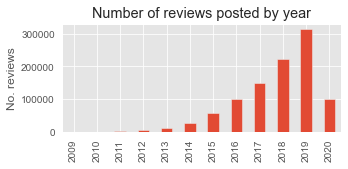

In [59]:
# plot the number of reviews by year (each row in the table is a review)

plt.style.use('ggplot')
plt.figure(figsize=(5,2))
reviews_data.year.value_counts(sort=False).plot(kind = "bar")
plt.title("Number of reviews posted by year")
plt.ylabel("No. reviews")

In [60]:
# remove rows with null review column as these aren't going to be useful for us 
reviews_data = reviews_data[reviews_data.comments.notnull()]

### Additional Reviews EDA

In [61]:
#Get the length of each review 
reviews_data['length'] = reviews_data.comments.apply(len)

In [62]:
reviews_data.head()

listing_id     id       date  reviewer_id reviewer_name  \
0        2595  17857 2009-11-21        50679          Jean   
1        2595  19176 2009-05-12        53267          Cate   
2        2595  19760 2009-10-12        38960         Anita   
3        2595  34320 2010-09-04        71130       Kai-Uwe   
4        2595  46312 2010-05-25       117113        Alicia   

                                            comments  year  length  
0  Notre séjour de trois nuits.\r\nNous avons app...  2009     707  
1                                  Great experience.  2009      17  
2  I've stayed with my friend at the Midtown Cast...  2009     471  
3  We've been staying here for about 9 nights, en...  2010     366  
4  We had a wonderful stay at Jennifer's charming...  2010     155

In [63]:
reviews_data.comments[1]

'Great experience.'

Text(0.5, 0, 'Review length (no. letters)')

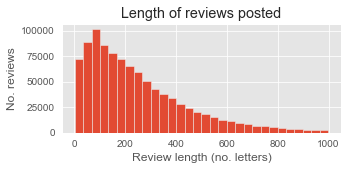

In [64]:
#plot the distribution of review length 
plt.style.use('ggplot')
plt.figure(figsize=(5,2))
reviews_data[reviews_data['length'] < 1000].length.hist(bins = 30)
plt.title("Length of reviews posted")
plt.ylabel("No. reviews")
plt.xlabel("Review length (no. letters)")

Text(0.5, 1.0, 'Distribution of review length')

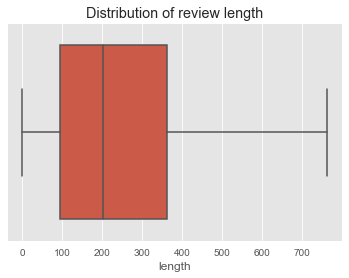

In [65]:
sns.boxplot(x=reviews_data.length, showfliers=False)
plt.title("Distribution of review length")

The majority of reviews are short with around 100-370 letters long, with a long tail of longer reviews. We can now look at the sentiment associated with each review.

In [66]:
# Define a function that accepts text and returns the polarity.
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [67]:
#apply function to reviews data
reviews_data['sentiment'] = reviews_data.comments.apply(detect_sentiment)

In [68]:
reviews_data.head()

listing_id     id       date  reviewer_id reviewer_name  \
0        2595  17857 2009-11-21        50679          Jean   
1        2595  19176 2009-05-12        53267          Cate   
2        2595  19760 2009-10-12        38960         Anita   
3        2595  34320 2010-09-04        71130       Kai-Uwe   
4        2595  46312 2010-05-25       117113        Alicia   

                                            comments  year  length  sentiment  
0  Notre séjour de trois nuits.\r\nNous avons app...  2009     707   0.000000  
1                                  Great experience.  2009      17   0.800000  
2  I've stayed with my friend at the Midtown Cast...  2009     471   0.410124  
3  We've been staying here for about 9 nights, en...  2010     366   0.266875  
4  We had a wonderful stay at Jennifer's charming...  2010     155   0.518750

Text(0, 0.5, 'No. reviews')

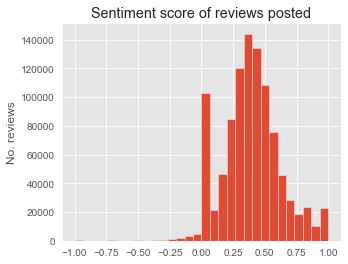

In [69]:
#plot the sentiment of reviews posted 
plt.style.use('ggplot')
plt.figure(figsize=(5,4))
reviews_data.sentiment.hist(bins = 30)
plt.title("Sentiment score of reviews posted")
plt.ylabel("No. reviews")

The 0 sentiment scores are definitely odd...

Text(0.5, 1.0, 'Distribution of review sentiment')

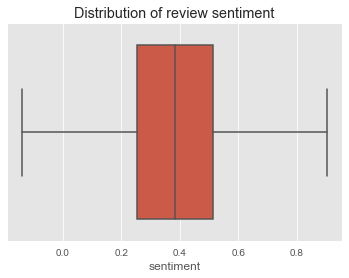

In [70]:
#Majority of reviews seem to have a sentiment score between 0.25 and 0.5. We don't have as many negative reviews as positive
sns.boxplot(x=reviews_data.sentiment, showfliers=False)
plt.title("Distribution of review sentiment")

In [71]:
#look at reviews with 0 sentiment 
reviews_data[reviews_data.sentiment == 0]

listing_id         id       date  reviewer_id    reviewer_name  \
0              2595      17857 2009-11-21        50679             Jean   
13             2595   21464102 2014-10-18     16584002            Kitty   
21             2595  194307810 2017-09-16     81450805           Marina   
33             2595  283276097 2018-06-29     51923495          Fabiola   
43             2595  449815873 2019-07-05    168460710      Christopher   
...             ...        ...        ...          ...              ...   
1002935    45349169  666468130 2020-09-20     76666954           Zavier   
1002937    45352043  664673023 2020-09-15    308678864  Genesis Eugenia   
1003009    45458243  667095121 2020-09-22    262934145        Mateo MRW   
1003028    45497044  667317749 2020-09-23    293886634            Freya   
1003062    45712092  671859717 2020-06-10    191594508               Fm   

                                                  comments  year  length  \
0        Notre séjour de trois nuits.\r\nNous avons app...  2009     707   
13       We hebben genoten van ons verblijf in het appa...  2014     222   
21       Tiene una ubicación excelente. Buen equipamien...  2017      93   
33       Jennifer es un anfitrión increíble. Siempre es...  2018     361   
43                                10 / 10 would stay again  2019      24   
...                                                    ...   ...     ...   
1002935                                  Place had roaches  2020      17   
1002937  Excelente lugar muy limpio y queda a pocos min...  2020     351   
1003009                         I’ll definitely stay again  2020      26   
1003028                                        Solid place  2020      11   
1003062         I would recommend this place for everyone.  2020      42   

         sentiment  
0              0.0  
13             0.0  
21             0.0  
33             0.0  
43             0.0  
...            ...  
1002935        0.0  
1002937        0.0  
1003009        0.0  
1003028        0.0  
1003062        0.0  

[93037 rows x 9 columns]

It looks like some of the reviews have been given a 0 sentiment score if they are in a different language. Some look like they haven't been scored correctly (e.g. "I would recommend this place for everyone" has a 0 sentiment score, as well as "Place had roaches"). Ideally I'd like to filter out the non-English reviews and correct some of the wrong ones, but I will leave them in for now as removing all the 0 scores will skew the average sentiment and manually adjusting the wrong ones will get tedious without another numerical score to impute it with. Some of these may truly have a neutral sentiment and I don't want to create any additional bias in the dataset by changing the scores around.  
I'll take a quick look at the extreme negative and positive reviews: 


In [72]:
#look at most positive reviews
reviews_data[reviews_data.sentiment == 1].head(-10)

listing_id         id       date  reviewer_id reviewer_name  \
102            3831   69193192 2016-10-04     48390970      Michelle   
249            3831  288777574 2018-10-07    142965005       Patrick   
300            3831  446482788 2019-01-05     77367154        Rachel   
320            3831  494043690 2019-07-23    124906176         EunBi   
423            5121     522601 2011-12-09       599217          Mara   
...             ...        ...        ...          ...           ...   
1002742    45188227  663828284 2020-09-13    365103399       Ulrique   
1002764    45203115  661150759 2020-06-09    272152811         Julio   
1002774    45203580  664367013 2020-09-14    350233043         James   
1002788    45216079  665414135 2020-09-18    165030181           Roy   
1002815    45235897  667495652 2020-09-24    367483543       Matilda   

                                                  comments  year  length  \
102      L'appartement est tel que décrit , propre et a...  2016     494   
249      Très bon séjour de trois semaines à NYC. Le lo...  2018     341   
300                                  This place was great!  2019      21   
320                                 The location is great!  2019      22   
423                             Garon is the best. Period.  2011      26   
...                                                    ...   ...     ...   
1002742                               Great place to stay!  2020      20   
1002764               This place is awesome and convenient  2020      36   
1002774                                  Awesome location.  2020      17   
1002788                  Great location, would stay again!  2020      33   
1002815  Florence place is the best place ever, I will ...  2020      74   

         sentiment  
102            1.0  
249            1.0  
300            1.0  
320            1.0  
423            1.0  
...            ...  
1002742        1.0  
1002764        1.0  
1002774        1.0  
1002788        1.0  
1002815        1.0  

[21185 rows x 9 columns]

Actually, there are some positively scored reviews in non-English languages so the ones with 0 sentiment probably are neutral. At a glance, it looks like these are all positive. 

In [73]:
#These reviews sound negative but there are very few of them 
reviews_data[reviews_data.sentiment == -1].head(-10)

listing_id         id       date  reviewer_id reviewer_name  \
9752         29455   12692033 2014-08-05     13610699        Audrey   
11508        32965  337569764 2018-10-16    165833974         Denis   
12407        39267  174323646 2017-07-25     82595088        Hugues   
17923        58059   61143311 2016-01-31     56622047       Uchenna   
20164        62787  155734638 2017-05-28    126485657     Alexander   
...            ...        ...        ...          ...           ...   
994264    41745187  635459543 2020-06-07    352573496         Piers   
994627    41873763  659661432 2020-02-09    364047566          Atif   
995656    42175851  615212491 2020-07-03    339866738      Mohammed   
995850    42247636  635926907 2020-08-07    303343308          Amie   
996288    42401212  629690408 2020-06-14    198866655         Cyrus   

                                                 comments  year  length  \
9752    nous avons séjourné 1 semaine dans l'apparteme...  2014    1232   
11508   Le proprio, Khem, est très gentil. L'apparteme...  2018     186   
12407   Il est inadmissible de louer un logement de la...  2017    1517   
17923   Terrible experience. No wifi in the room. Adve...  2016     178   
20164   Für jeden der einfach nur eine Unterkunft zum ...  2017     389   
...                                                   ...   ...     ...   
994264  Horrible landlord staff, verbally abused me fo...  2020     103   
994627                                           HORRIBLE  2020       8   
995656                                              Worst  2020       5   
995850                                      Horrible stay  2020      13   
996288                           WiFi service is horrible  2020      24   

        sentiment  
9752         -1.0  
11508        -1.0  
12407        -1.0  
17923        -1.0  
20164        -1.0  
...           ...  
994264       -1.0  
994627       -1.0  
995656       -1.0  
995850       -1.0  
996288       -1.0  

[266 rows x 9 columns]

I would now like to get the average sentiment score per listing id so I can add it as a column in my original listings dataframe 

In [74]:
#Get the mean sentiment score per property
reviews_per_listing = pd.DataFrame(reviews_data.groupby("listing_id")['sentiment'].mean())

Text(0.5, 1.0, 'Average sentiment score per property')

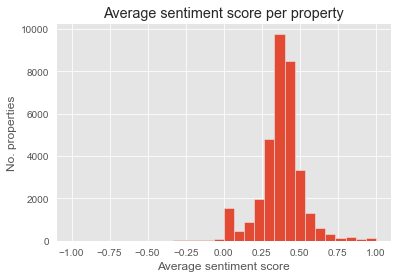

In [75]:
#Visualise the average score per property
reviews_per_listing.sentiment.hist(bins = 30)
plt.xlabel("Average sentiment score")
plt.ylabel("No. properties")
plt.title("Average sentiment score per property")

Text(0.5, 1.0, 'Distribution of sentiment per listing')

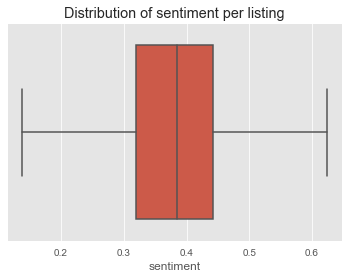

In [76]:
#sentiment looks evenly distributed and fairly normal aside from the peak at 0 
sns.boxplot(x=reviews_per_listing.sentiment, showfliers=False)
plt.title("Distribution of sentiment per listing")

Before adding this column on the `listings_data` dataframe, I'll quickly check we don't have any duplicate listing id's:

In [77]:
listings_data.id.unique().shape

(48137,)

In [78]:
listings_data.shape

(48137, 17)

Doesn't look like we have any duplicate rows so we're good to join on the average sentiment score

In [79]:
# convert listing id to string
reviews_per_listing['listing_id_2'] = reviews_per_listing.index
reviews_per_listing['listing_id_2'] = reviews_per_listing['listing_id_2'].apply(str)


In [80]:
reviews_per_listing.head()

sentiment listing_id_2
listing_id                        
2595         0.337270         2595
3831         0.355942         3831
5121         0.409002         5121
5136         0.484073         5136
5178         0.289852         5178

In [81]:
#join average sentiment on to listings data 
listings_data = listings_data.merge(reviews_per_listing, left_on = 'id', right_on='listing_id_2', how = 'left')

In [82]:
listings_data.head()

id                                              name host_id  \
0  2539                Clean & quiet apt home by the park    2787   
1  2595                             Skylit Midtown Castle    2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !    4632   
3  3831                   Cozy Entire Floor of Brownstone    4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park    7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.21                               6               365   
1               0.38                               2               355   
2                NaN                               1               365   
3               4.64                               1               194   
4               0.10                               1                 0   

   log_price  sentiment listing_id_2  
0   5.003946        NaN          NaN  
1   5.416100   0.337270         2595  
2   5.010635        NaN          NaN  
3   4.488636   0.355942         3831  
4   4.382027        NaN          NaN

In [83]:
# Impute the missing sentiment values with 0 
listings_data.sentiment.fillna(0, inplace=True)

In [84]:
# Define a function that accepts text and returns the language.
def detect_language(text):
    return TextBlob(text).detect_language()

In [85]:
#reviews_data['language'] = reviews_data.comments.apply(detect_language)
## couldn't get this to work 

### Detailed listings data
The detailed dataset below has more information on the property which may help in predicting the price of each listing, such as the review score, the number of guests each rental can accommodate, the number of bathrooms etc. 
However, we will have to check how many listings we can join on to.

In [86]:
#import the data
path_4 = r'./Data/listings_detailed.csv'
listings_detailed = pd.read_csv(path_4)

In [87]:
listings_detailed.head()

id                        listing_url     scrape_id last_scraped  \
0  2595  https://www.airbnb.com/rooms/2595  2.020120e+13   11/12/2020   
1  3831  https://www.airbnb.com/rooms/3831  2.020120e+13   11/12/2020   
2  5121  https://www.airbnb.com/rooms/5121  2.020120e+13   11/12/2020   
3  5178  https://www.airbnb.com/rooms/5178  2.020120e+13   11/12/2020   
4  5203  https://www.airbnb.com/rooms/5203  2.020120e+13   11/12/2020   

                                                name  \
0                              Skylit Midtown Castle   
1  Whole flr w/private bdrm, bath & kitchen(pls r...   
2                                    BlissArtsSpace!   
3                   Large Furnished Room Near B'way　   
4                 Cozy Clean Guest Room - Family Apt   

                                         description  \
0  Beautiful, spacious skylit studio in the heart...   
1  Enjoy 500 s.f. top floor in 1899 brownstone, w...   
2  <b>The space</b><br />HELLO EVERYONE AND THANK...   
3  Please don’t expect the luxury here just a bas...   
4  Our best guests are seeking a safe, clean, spa...   

                               neighborhood_overview  \
0  Centrally located in the heart of Manhattan ju...   
1  Just the right mix of urban center and local n...   
2                                                NaN   
3    Theater district, many restaurants around here.   
4  Our neighborhood is full of restaurants and ca...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/f0813a11-40b2...     2845   
1  https://a0.muscache.com/pictures/e49999c2-9fd5...     4869   
2  https://a0.muscache.com/pictures/2090980c-b68e...     7356   
3  https://a0.muscache.com/pictures/12065/f070997...     8967   
4  https://a0.muscache.com/pictures/103776/b37157...     7490   

                                 host_url  ... review_scores_communication  \
0  https://www.airbnb.com/users/show/2845  ...                        10.0   
1  https://www.airbnb.com/users/show/4869  ...                         9.0   
2  https://www.airbnb.com/users/show/7356  ...                        10.0   
3  https://www.airbnb.com/users/show/8967  ...                         9.0   
4  https://www.airbnb.com/users/show/7490  ...                        10.0   

  review_scores_location review_scores_value license instant_bookable  \
0                   10.0                 9.0     NaN                f   
1                   10.0                10.0     NaN                f   
2                    9.0                 9.0     NaN                f   
3                   10.0                 9.0     NaN                f   
4                   10.0                10.0     NaN                f   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              2                                           2   
1                              1                                           1   
2                              1                                           0   
3                              1                                           0   
4                              1                                           0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            1   
3                                            1   
4                                            1   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.36  
1                                           0              4.97  
2                                           0              0.36  
3                                           0              3.36  
4                                           0              0.86  

[5 rows x 74 columns]

In [88]:
listings_detailed.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Since this detailed listings data was scraped in 2020 and the original `listings` data was scraped in 2019, I want to check how many I can join on before using this data. If I still have enough rows, I will be able to join the two together and still have enough rows to model on. 

In [89]:
#get unique listings in detailed listings data
listings_detail_listings = pd.DataFrame(listings_detailed.id.unique())

In [90]:
listings_detail_listings.rename(columns = {0 : "listing_id"}, inplace=True)

listings_detail_listings["listing_id"] = listings_detail_listings["listing_id"].apply(str)

In [91]:
# join on to listings data to see how many we can join on 
joined_ids_2 = listings_detail_listings.merge(listings_listings, how = 'inner')

In [92]:
#looks like we can join on ~23k listings
joined_ids_2.shape

(22553, 1)

In [93]:
#select only the columns I'm interested in 
columns = ['id', 'neighborhood_overview', 'accommodates', 'bathrooms', 'beds', 'bedrooms', 
                                              'amenities', 'review_scores_rating']
listings_detailed_columns = listings_detailed[columns]

In [94]:
listings_detailed_columns.head()

id                              neighborhood_overview  accommodates  \
0  2595  Centrally located in the heart of Manhattan ju...             2   
1  3831  Just the right mix of urban center and local n...             3   
2  5121                                                NaN             2   
3  5178    Theater district, many restaurants around here.             2   
4  5203  Our neighborhood is full of restaurants and ca...             1   

   bathrooms  beds  bedrooms  \
0        NaN   1.0       NaN   
1        NaN   3.0       1.0   
2        NaN   1.0       1.0   
3        NaN   1.0       1.0   
4        NaN   1.0       1.0   

                                           amenities  review_scores_rating  
0  ["Hot water", "Extra pillows and blankets", "O...                  94.0  
1  ["Hot water", "Shampoo", "Baby safety gates", ...                  89.0  
2  ["Wifi", "Kitchen", "Heating", "Air conditioni...                  90.0  
3  ["Wifi", "Heating", "Refrigerator", "Shampoo",...                  84.0  
4  ["Wifi", "Heating", "Hot water", "Shampoo", "F...                  98.0

In [95]:
listings_detailed_columns["id"] = listings_detailed_columns["id"].apply(str)

C:\Users\hmalek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
#join onto original dataset 
listings_data = listings_data.merge(listings_detailed_columns, left_on = 'id', right_on='id', how = 'inner')

In [97]:
listings_data.shape

(22553, 26)

I still have ~23000 rows so this new joined dataset should be large enough to use. I'll check for null values later.  

Text(0.5, 1.0, 'No. guests accommodated per listing')

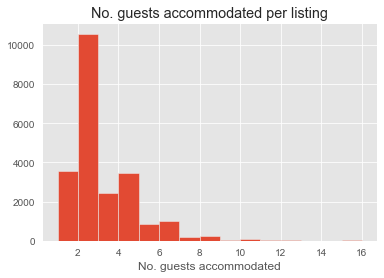

In [98]:
#plot accommodates histogram - the majority of listings accommodate 2 guests
plt.style.use('ggplot')
listings_data.accommodates.hist(bins=15)
plt.xlabel("No. guests accommodated")
plt.title("No. guests accommodated per listing")

Text(0.5, 1.0, 'Review score per listing')

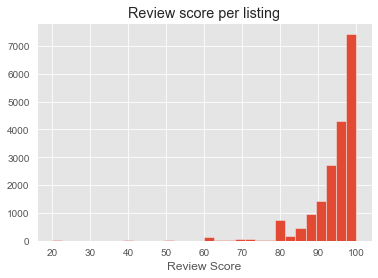

In [99]:
#plot review score histogram -
plt.style.use('ggplot')
listings_data.review_scores_rating.hist(bins=30)
plt.xlabel("Review Score")
plt.title("Review score per listing")

I'm not sure how exactly the review score has been calculated, so maybe we can leave this out and try adding it in later to see if it improves our model performance at all by adding it in. We do have the sentiment score already so maybe we can use one or the other. 

## Predicting price
### Feature Engineering
We'll first need to do some feature engineering. I will turn `neighbourhood_group` and `room_type` into one-hot-encoded variables using the pandas `get_dummies` function. 

In [100]:
listings_data.head()

id                                            name host_id    host_name  \
0  2595                           Skylit Midtown Castle    2845     Jennifer   
1  3831                 Cozy Entire Floor of Brownstone    4869  LisaRoxanne   
2  5178                Large Furnished Room Near B'way     8967     Shunichi   
3  5203              Cozy Clean Guest Room - Family Apt    7490    MaryEllen   
4  5803  Lovely Room 1, Garden, Best Area, Legal rental    9744       Laurie   

  neighbourhood_group    neighbourhood  latitude  longitude        room_type  \
0           Manhattan          Midtown  40.75362  -73.98377  Entire home/apt   
1            Brooklyn     Clinton Hill  40.68514  -73.95976  Entire home/apt   
2           Manhattan   Hell's Kitchen  40.76489  -73.98493     Private room   
3           Manhattan  Upper West Side  40.80178  -73.96723     Private room   
4            Brooklyn      South Slope  40.66829  -73.98779     Private room   

   price  ...  log_price  sentiment listing_id_2  \
0    225  ...   5.416100   0.337270         2595   
1     89  ...   4.488636   0.355942         3831   
2     79  ...   4.369448   0.289852         5178   
3     79  ...   4.369448   0.428167         5203   
4     89  ...   4.488636   0.407715         5803   

                               neighborhood_overview  accommodates  bathrooms  \
0  Centrally located in the heart of Manhattan ju...             2        NaN   
1  Just the right mix of urban center and local n...             3        NaN   
2    Theater district, many restaurants around here.             2        NaN   
3  Our neighborhood is full of restaurants and ca...             1        NaN   
4  Neighborhood is amazing!<br />Best subways to ...             2        NaN   

   beds  bedrooms                                          amenities  \
0   1.0       NaN  ["Hot water", "Extra pillows and blankets", "O...   
1   3.0       1.0  ["Hot water", "Shampoo", "Baby safety gates", ...   
2   1.0       1.0  ["Wifi", "Heating", "Refrigerator", "Shampoo",...   
3   1.0       1.0  ["Wifi", "Heating", "Hot water", "Shampoo", "F...   
4   0.0       1.0  ["Hot water", "Shampoo", "Patio or balcony", "...   

  review_scores_rating  
0                 94.0  
1                 89.0  
2                 84.0  
3                 98.0  
4                 94.0  

[5 rows x 26 columns]

Looks like `bathrooms` is always null so we won't be able to use this information.

In [101]:
# Use get_dummies to one hot encode neighbourhood group
neighbourhood_dummies = pd.get_dummies(listings_data.neighbourhood_group, prefix = 'neighbourhood', drop_first=True)

In [102]:
# concatenate with original dataset 
listings_data_2 = pd.concat([listings_data, neighbourhood_dummies], axis =1)


In [103]:
# one hot encode the room type
room_type_dummies = pd.get_dummies(listings_data_2.room_type, prefix = 'room', drop_first=True)

In [104]:
# concatenate with original dataset and neighbourhood dummies 
listings_data_3 = pd.concat([listings_data_2, room_type_dummies], axis =1)


In [105]:
listings_data_3.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'log_price', 'sentiment', 'listing_id_2',
       'neighborhood_overview', 'accommodates', 'bathrooms', 'beds',
       'bedrooms', 'amenities', 'review_scores_rating',
       'neighbourhood_Brooklyn', 'neighbourhood_Manhattan',
       'neighbourhood_Queens', 'neighbourhood_Staten Island',
       'room_Private room', 'room_Shared room'],
      dtype='object')

In [106]:
listings_data_3.fillna({'reviews_per_month':0}, inplace=True)

#### Calculating distance from popular locations
According to TripAdvisor, the top attractions in NYC are Central Park, The Met (Museum of Art), Brooklyn Bridge, Empire State Building, Broadway and Grand Central Terminal. Since the majority of these are in Manhattan, I'll pick Central Park as a proxy as well as Brooklyn Bridge as it's one of the main attractions not in Manhattan. I can enter their coordinates in a dataframe and calculate the distance from each listing to these attractions. The file I read in below has the coordinates of the main attractions: 

In [107]:
#read in the csv I put together after collecting location coordinates
path_3 = r'./Data/Attractions.csv'
attractions = pd.read_csv(path_3)

In [108]:
attractions.head(10)

place   latitude  longitude
0           Central Park  40.785091 -73.968285
1  Empire State Building  40.748817 -73.985428
2            Wall Street  40.706005 -74.008827
3          Grand Central  40.752655 -73.977295
4        Brooklyn Bridge  40.706001 -73.997002
5      Statue of Liberty  40.689247 -74.044502
6           Times Square  40.758896 -73.985130
7                The Met  40.778965 -73.962311
8                    JFK  40.644167 -73.782222
9                    LGA  40.777324 -73.875136

Text(0.5, 1.0, 'Geographic visualisation of attractions in NYC')

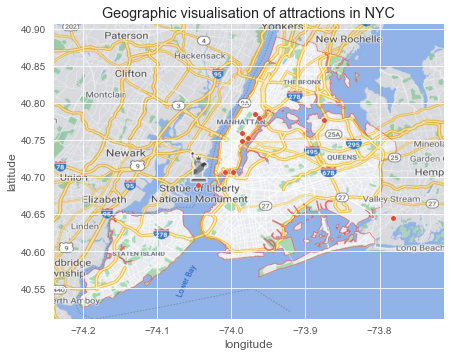

In [109]:
#visualise the locations to check we don't have too many in similar areas 
plt.style.use('ggplot')
plt.figure(figsize=(7,7))
#import map image
img=plt.imread('C:/Users/hmalek/Documents/General_Assembly/projects/project-final/Data/NYC 2.JPG',0)


# Graph and image settings
plt.imshow(img, zorder=0, extent=[listings_data['longitude'].min(),listings_data['longitude'].max(),
                                listings_data['latitude'].min(),listings_data['latitude'].max()])

# When an image is included, use it.
ax = plt.gca()

#plot a scatterplot of the properties with the hue reflecting log price
palette = sns.color_palette("Reds")

sns.scatterplot(x="longitude", y="latitude", data = attractions, 
                palette= palette, s=30)

plt.title("Geographic visualisation of attractions in NYC")

Now that I have my attractions, I can calculate the distances from these to the properties and use these as features. We have quite a few in Manhattan so we won't use all these locations. 

In [110]:
import mpu

#check it works- print distance between Central Park and the Empire State Building
dist = mpu.haversine_distance((attractions.latitude[0], attractions.longitude[0]), (attractions.latitude[1], attractions.longitude[1]))
print("The distance between ", attractions.place[0], " and ", attractions.place[1], " is ", dist,"km ") # prints the distance in km

The distance between  Central Park  and  Empire State Building  is  4.284075974112244 km 


The functions below iterate through every row in the dataframe and use the latitude and longitude coordinates to find the distance between the listing and the attractions.

In [111]:
def get_distance_central_park(data):
    dist = []
    for i in range(len(data)):
        dist.append(mpu.haversine_distance((data.latitude[i], data.longitude[i]), (attractions.latitude[0], attractions.longitude[0])))
    return dist

In [112]:
def get_distance_brooklyn_bridge(data):
    dist = []
    for i in range(len(data)):
        dist.append(mpu.haversine_distance((data.latitude[i], data.longitude[i]), (attractions.latitude[4], attractions.longitude[4])))
    return dist

In [113]:
def get_distance_LGA(data):
    dist = []
    for i in range(len(data)):
        dist.append(mpu.haversine_distance((data.latitude[i], data.longitude[i]), (attractions.latitude[9], attractions.longitude[9])))
    return dist

In [114]:
def get_distance_JFK(data):
    dist = []
    for i in range(len(data)):
        dist.append(mpu.haversine_distance((data.latitude[i], data.longitude[i]), (attractions.latitude[8], attractions.longitude[8])))
    return dist

In [115]:
def get_distance_statue_liberty(data):
    dist = []
    for i in range(len(data)):
        dist.append(mpu.haversine_distance((data.latitude[i], data.longitude[i]), (attractions.latitude[5], attractions.longitude[5])))
    return dist

In [116]:
# Add distance from Central Park as a column
listings_data_3['dist_central_park'] = get_distance_central_park(listings_data_3)

In [117]:
# Add distance from Brooklyn Bridge as a column
listings_data_3['dist_brooklyn_bridge'] = get_distance_brooklyn_bridge(listings_data_3)

In [118]:
# Add distance from LaGuardia Airport as a column
listings_data_3['dist_LGA_airport'] = get_distance_LGA(listings_data_3)

In [119]:
# Add distance from JFK Airport as a column
listings_data_3['dist_JFK_airport'] = get_distance_JFK(listings_data_3)

In [120]:
# Add distance from the Statue of Liberty as a column
listings_data_3['dist_statue_liberty'] = get_distance_statue_liberty(listings_data_3)

In [121]:
listings_data_3.head()

id                                            name host_id    host_name  \
0  2595                           Skylit Midtown Castle    2845     Jennifer   
1  3831                 Cozy Entire Floor of Brownstone    4869  LisaRoxanne   
2  5178                Large Furnished Room Near B'way     8967     Shunichi   
3  5203              Cozy Clean Guest Room - Family Apt    7490    MaryEllen   
4  5803  Lovely Room 1, Garden, Best Area, Legal rental    9744       Laurie   

  neighbourhood_group    neighbourhood  latitude  longitude        room_type  \
0           Manhattan          Midtown  40.75362  -73.98377  Entire home/apt   
1            Brooklyn     Clinton Hill  40.68514  -73.95976  Entire home/apt   
2           Manhattan   Hell's Kitchen  40.76489  -73.98493     Private room   
3           Manhattan  Upper West Side  40.80178  -73.96723     Private room   
4            Brooklyn      South Slope  40.66829  -73.98779     Private room   

   price  ...  neighbourhood_Manhattan  neighbourhood_Queens  \
0    225  ...                        1                     0   
1     89  ...                        0                     0   
2     79  ...                        1                     0   
3     79  ...                        1                     0   
4     89  ...                        0                     0   

  neighbourhood_Staten Island  room_Private room  room_Shared room  \
0                           0                  0                 0   
1                           0                  0                 0   
2                           0                  1                 0   
3                           0                  1                 0   
4                           0                  1                 0   

   dist_central_park  dist_brooklyn_bridge  dist_LGA_airport dist_JFK_airport  \
0           3.734490              5.411107          9.521023        20.900116   
1          11.137231              3.903672         12.486584        15.652253   
2           2.647665              6.626684          9.348626        21.729521   
3           1.857856             10.941406          8.216218        23.456955   
4          13.091268              4.264603         15.398688        17.547135   

  dist_statue_liberty  
0            8.799501  
1            7.159761  
2            9.795228  
3           14.105066  
4            5.319920  

[5 rows x 37 columns]

### Linear Regression

We can see in the correlation plot below that a few of our features are highly correlated with one another and this would probably affect our linear regression coefficients, e.g. `dist_central_park` and `dist_LGA_airport`. 

`dist_statue_liberty` and `dist_brooklyn_bridge` are almost perfectly correlated with one another, so we will only use one of these as a feature. 
Also, `accommodates` is highly correlated with `beds` and we may not need both, so we will use `accommodates` only as they both indicate the same thing. I chose `accommodates` as it may be more indicative, since a single and double bed would both class as one bed, but one accommodates 2 guests while the other accommodates 1, and listings that accommodate 2 guests are probably more expensive than those that accommodate 1.  

In [122]:
#select my feature columns
feature_cols = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'neighbourhood_Brooklyn', 
               'neighbourhood_Manhattan', 'neighbourhood_Queens', 'neighbourhood_Staten Island', 'room_Private room',
                'room_Shared room', 'sentiment', 'dist_central_park', 'dist_brooklyn_bridge', 'dist_LGA_airport', 
                'dist_JFK_airport', 'dist_statue_liberty', 'accommodates', 'beds', 'review_scores_rating']

In [123]:
X = listings_data_3[feature_cols]
y = listings_data_3.price

<AxesSubplot:>

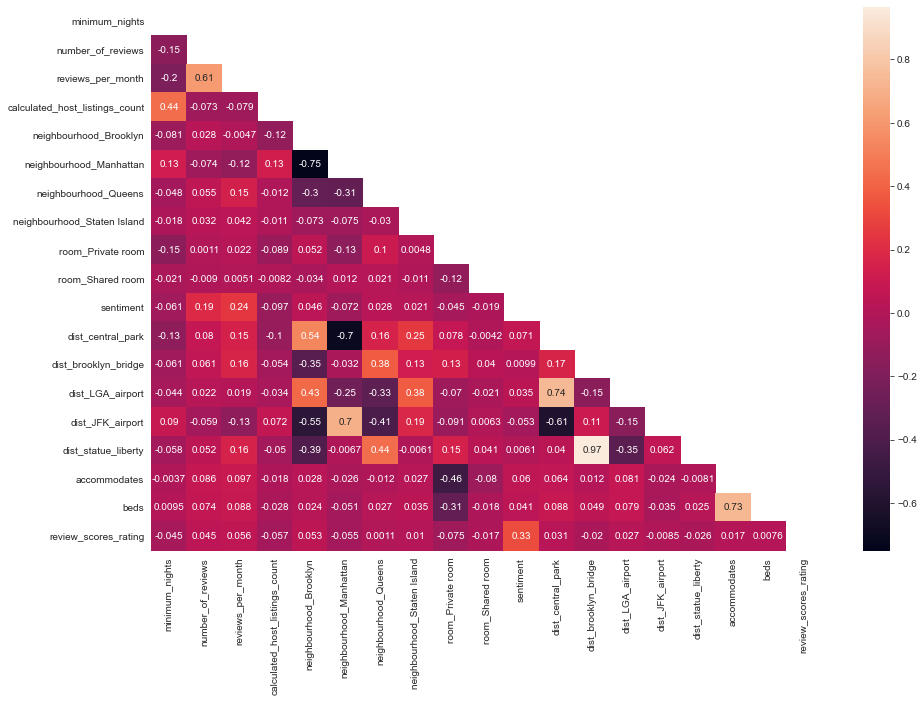

In [124]:
#plot correlations between features
corr = X.corr()

# Exclude duplicate correlations by masking uper right values
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set background color / chart style
sns.set_style(style = 'white')

plt.figure(figsize=(15,10))
sns.heatmap(corr, annot = True, mask= mask)

In [125]:
#remove dist_statue_liberty from feature cols due to high correlation coefficient with dist_brooklyn_bridge
feature_cols = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'neighbourhood_Brooklyn', 
               'neighbourhood_Manhattan', 'neighbourhood_Queens', 'neighbourhood_Staten Island', 'room_Private room',
                'room_Shared room', 'sentiment', 'dist_central_park', 'dist_brooklyn_bridge', 'dist_LGA_airport', 
                'dist_JFK_airport', 'accommodates', 'review_scores_rating']

In [126]:
listings_data_3[feature_cols].isnull().sum()

minimum_nights                       0
number_of_reviews                    0
reviews_per_month                    0
calculated_host_listings_count       0
neighbourhood_Brooklyn               0
neighbourhood_Manhattan              0
neighbourhood_Queens                 0
neighbourhood_Staten Island          0
room_Private room                    0
room_Shared room                     0
sentiment                            0
dist_central_park                    0
dist_brooklyn_bridge                 0
dist_LGA_airport                     0
dist_JFK_airport                     0
accommodates                         0
review_scores_rating              3875
dtype: int64

We don't want any null values in our data, since there aren't many under `review_scores_rating` we can take the non-null values only.

In [127]:
listings_data_4 = listings_data_3[listings_data_3['review_scores_rating'].notnull()]

In [128]:
#we still have around 18k rows so I'm happy with this
listings_data_4.shape

(18678, 37)

In [129]:
X = listings_data_4[feature_cols]
y = listings_data_4['price']

In [130]:
#check we don't have any null values
X.isnull().sum()

minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
neighbourhood_Brooklyn            0
neighbourhood_Manhattan           0
neighbourhood_Queens              0
neighbourhood_Staten Island       0
room_Private room                 0
room_Shared room                  0
sentiment                         0
dist_central_park                 0
dist_brooklyn_bridge              0
dist_LGA_airport                  0
dist_JFK_airport                  0
accommodates                      0
review_scores_rating              0
dtype: int64

In [131]:
#create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 99)

In [132]:
#check the sizes of our splits
print(X_train.shape)
print(X_test.shape)

(13074, 17)
(5604, 17)


In [133]:
#Instantiate the Linear Regression function
lr = LinearRegression()

In [134]:
#Fit the model on the training set 
lr.fit(X_train,y_train)
#print the coefficients of the linear regression equation 
list(zip(feature_cols, lr.coef_))

[('minimum_nights', -0.4833934980558685),
 ('number_of_reviews', -0.11438373828866262),
 ('reviews_per_month', -4.217711392308785),
 ('calculated_host_listings_count', 0.03773060378705876),
 ('neighbourhood_Brooklyn', -58.86611679901699),
 ('neighbourhood_Manhattan', -7.1782344839120205),
 ('neighbourhood_Queens', -19.248061563157666),
 ('neighbourhood_Staten Island', -75.25334472031524),
 ('room_Private room', -26.36831776463863),
 ('room_Shared room', -27.481400803469135),
 ('sentiment', 36.58941168891205),
 ('dist_central_park', -7.517692139809449),
 ('dist_brooklyn_bridge', -3.7767862783746917),
 ('dist_LGA_airport', 7.88774987877894),
 ('dist_JFK_airport', -2.367873720502237),
 ('accommodates', 38.915849796361904),
 ('review_scores_rating', 0.7981859099995211)]

C:\Users\hmalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


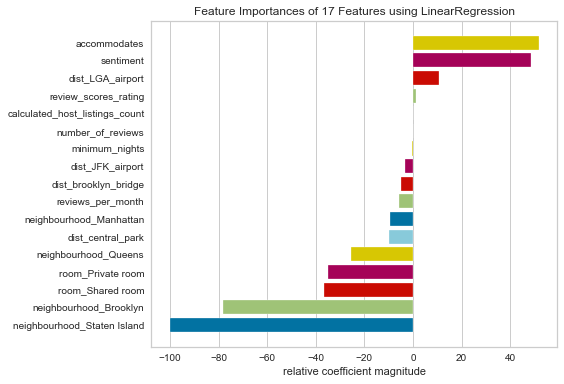

In [135]:
#plot feature importances
from yellowbrick.model_selection import feature_importances


feature_importances(lr, X_train, y_train);

The model suggests `neighbourhood_Staten_Island` is the most important feature, followed by `neighbourhood_Brooklyn` and then `accommodates`. 

`neighbourhood_Staten_Island` has a negative coefficient of -75, which indicates a highly negative effect on price if the listing is in Staten Island. Holding all other variables fixed, a 1 unit increase in `neighbourhood_Staten_Island` leads to a `$75` drop in price.  
`accommodates` has the most positive effect on price: holding all other variables fixed, a 1 unit increase in `accommodates` increases the daily price by almost `$39`. 

Let's see how the model performs in predictions. 

In [136]:
#cross-validate on our train set to get the average RMSE using 10 folds 
linreg_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print('===')
print('Fold RMSEs:')
print(np.sqrt(-linreg_scores))
print('===')
print('Average RMSE: {}'.format(np.mean(np.sqrt(-linreg_scores))))
print('STD of RMSE: {}'.format(np.std(np.sqrt(-linreg_scores))))
print('===')
print('Baseline RMSE: {}'.format(np.sqrt(mean_squared_error(y, np.repeat(np.mean(y),len(y))))))

===
Fold RMSEs:
[141.41713711 129.00185386 150.49891357 112.14822205  97.83399723
 162.14661712 105.6019334  222.63971854 197.9144901  296.95805238]
===
Average RMSE: 161.61609353488845
STD of RMSE: 58.82794752221861
===
Baseline RMSE: 180.5246212955117


In [137]:
#Predict on the test set 
y_pred = lr.predict(X_test)
print("RMSE on test set: ", metrics.mean_squared_error(y_test, y_pred, squared=False))

RMSE on test set:  133.56566605016553


The RMSE on the test set is lower than the baseline (null) model which shows it is making an improvement. The test RMSE is lower than the average train RMSE which is slightly strange, however some of our cross-validated train RMSE's were in the same region as the test RMSE and so it's possibly just the split we have used and that the model predicts better on our selected test set. Since the average rental price was `$152`, our RMSE here isn't great and it could be because we have so many extreme values. Since the majority of listings were less than `$500` per night, I will take these properties only and firstly try to predict rental prices of these. We can then look at whether we have enough data on the expensive listings to predict expensive rental prices as a next step. 



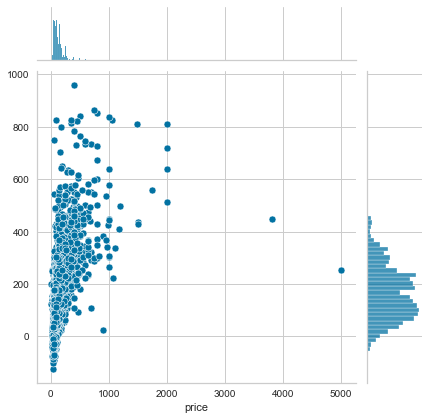

In [138]:
#plot predicted values against actual values 
sns.jointplot(x=y_test,y=y_pred);

We can see here that the predictions are mostly in the range of `$100-300` per night, and so our model isn't performing well on the highly priced properties. Let's split the data and look at rentals priced less than `$500` per night, and see if we can fit a linear regression on this data with as low an RMSE as possible. 

In [139]:
#check how many listings we'd be removing by taking out properties > $500 per night

print(listings_data_4.shape)

#filter on properties less than $500 per night
listings_data_cheap = listings_data_4[listings_data_4.price < 500]
print(listings_data_cheap.shape)

(18678, 37)
(18367, 37)


It looks as though only 300 out of 18,678 properties were priced above 500, so let's go with the majority and see if we can get better predictions. 

In [140]:
#select features I want to use 
feature_cols = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'neighbourhood_Brooklyn', 
               'neighbourhood_Manhattan', 'neighbourhood_Queens', 'neighbourhood_Staten Island', 'room_Private room',
                'room_Shared room', 'sentiment', 'dist_central_park', 'dist_brooklyn_bridge', 'dist_LGA_airport', 
                'dist_JFK_airport', 'accommodates', 'review_scores_rating']

#check we don't have null values
listings_data_cheap[feature_cols].isnull().sum()

minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
neighbourhood_Brooklyn            0
neighbourhood_Manhattan           0
neighbourhood_Queens              0
neighbourhood_Staten Island       0
room_Private room                 0
room_Shared room                  0
sentiment                         0
dist_central_park                 0
dist_brooklyn_bridge              0
dist_LGA_airport                  0
dist_JFK_airport                  0
accommodates                      0
review_scores_rating              0
dtype: int64

In [141]:
X = listings_data_cheap[feature_cols]
y = listings_data_cheap['price']

In [142]:
#create train and test splits using the same random state as above 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 99)

In [143]:
print(X_train.shape)
print(X_test.shape)

(12856, 17)
(5511, 17)


In [144]:
#Fit the model on the training set 
lr = LinearRegression()
lr.fit(X_train,y_train)

pd.DataFrame(list(zip(feature_cols, lr.coef_)), columns=["Feature", "Coefficient"]).sort_values(by="Coefficient", ascending=False)

Feature  Coefficient
15                    accommodates    19.408591
10                       sentiment    14.725464
13                dist_LGA_airport     5.921012
16            review_scores_rating     0.475963
3   calculated_host_listings_count     0.232730
1                number_of_reviews    -0.061842
0                   minimum_nights    -0.932086
14                dist_JFK_airport    -0.960785
2                reviews_per_month    -1.255495
12            dist_brooklyn_bridge    -3.283068
11               dist_central_park    -5.334286
6             neighbourhood_Queens   -11.264575
5          neighbourhood_Manhattan   -12.319160
4           neighbourhood_Brooklyn   -44.699686
8                room_Private room   -48.184041
7      neighbourhood_Staten Island   -64.731409
9                 room_Shared room   -67.296029

C:\Users\hmalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


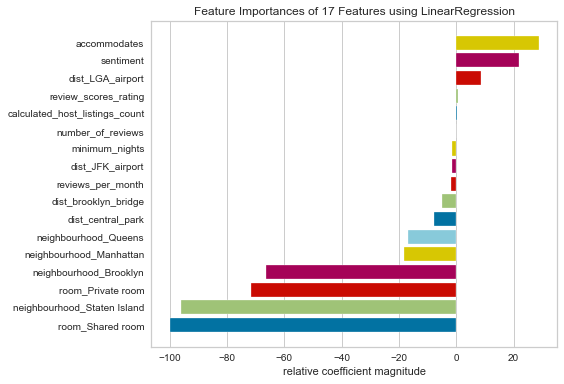

In [145]:
#plot feature importances 
feature_importances(lr, X_train, y_train);

This model suggests the most important feature is `room_shared_room`, followed by `neighbourhood_Staten_Island`. 

Holding all other variables constant, when `room_shared_room` = 1, it leads to a `$67` decrease in price per night. There are also some features here with very little importance in comparison to our important ones, such as `review_scores_rating` and `number_of_reviews`. 

In [146]:
#cross-validate on our train set to get the average RMSE using 10 folds 
linreg_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print('===')
print('Fold RMSEs:')
print(np.sqrt(-linreg_scores))
print('===')
print('Average RMSE: {}'.format(np.mean(np.sqrt(-linreg_scores))))
print('STD of RMSE: {}'.format(np.std(np.sqrt(-linreg_scores))))
print('===')
print('Baseline RMSE: {}'.format(np.sqrt(mean_squared_error(y, np.repeat(np.mean(y),len(y))))))

===
Fold RMSEs:
[55.68814394 59.14050059 53.48304118 52.28127393 56.24593169 58.39258477
 51.89342288 54.55726156 53.36908425 50.76642267]
===
Average RMSE: 54.5817667448188
STD of RMSE: 2.627786355075701
===
Baseline RMSE: 79.48252574715806


In [147]:
#Predict on the test set 
y_pred = lr.predict(X_test)
print("RMSE on test set: ", metrics.mean_squared_error(y_test, y_pred, squared=False))

RMSE on test set:  61.83695794181065


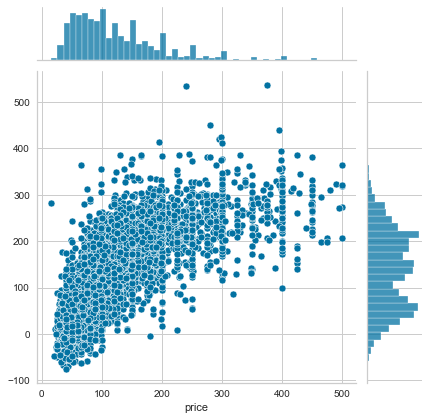

In [148]:
#plot actuals vs predicted
sns.jointplot(x=y_test,y=y_pred)


Now we can see that our test RMSE is slightly higher than our average cross-validated train RMSE, which shows our model is slightly overfitted. A RMSE of ~`$62` isn't great, as on average, this indicates a price prediction error of `$62`. But what if the listing should only be priced at `$60?` We can see in the plot above that the model predicts some negative prices! 

The other downside to this is that the price of a new property which should be valued higher than `$500` may not be predicted well enough, and so we would need to think of a more creative solution which caters for such properties (or firstly classify whether a property is cheap, medium or expensive and then use a regression model to predict the price depending on the category it falls into - but this is then using two models which may result in larger errors for some properties). For now, we will focus on these cheaper rentals only and look at the expensive ones as a next step. 

#### Regularised Regression

Since we have a large number of coefficients, some of which are highly correlated, we can try adding a penalty function using either Ridge Regression or LASSO to reduce overfitting and penalise the coefficients. However, to compare against the standard linear regression, we'll first use `alpha = 0` to understand the RMSE using standardised features and compare this using the cross-validated value of `alpha`. 

In [149]:
# alpha=0 is equivalent to linear regression.
from sklearn.linear_model import Ridge

# Instantiate the model.
#(Alpha of zero has no regularization strength, essentially a basic linear regression.)
ridgereg = Ridge(alpha=0, normalize=True)

# Fit the model.
ridgereg.fit(X_train, y_train)

# Predict with fitted model.
y_pred = ridgereg.predict(X_test)
print("Test RMSE (Ridge Regression using alpha = 0): ", metrics.mean_squared_error(y_test, y_pred, squared = False))
print("This is the same as our test RMSE above as it is equivalent to linear regression since the penalty function is 0")

Test RMSE (Ridge Regression using alpha = 0):  54.02433158270527
This is the same as our test RMSE above as it is equivalent to linear regression since the penalty function is 0


In [150]:
# Initialize the StandardScaler object to standardise our feature sets (required for ridge regression)
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [151]:
#find the optimal value of alpha to use for ridge regression
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10, scoring='neg_mean_squared_error')
optimal_ridge.fit(Xs_train, y_train)

print(optimal_ridge.alpha_)

6.368249944718588


In [152]:
#fit the ridge regression model using the optimal alpha value found above and get the average train RMSE
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_train, y_train, cv=10, scoring='neg_mean_squared_error')

print('Fold RMSEs:')
print(np.sqrt(-ridge_scores))
print('===')
print('Average RMSE: {}'.format(np.mean(np.sqrt(-ridge_scores))))

print('STD of RMSE: {}'.format(np.std(np.sqrt(-ridge_scores))))

Fold RMSEs:
[55.69022316 59.14555785 53.48038474 52.28357546 56.24860396 58.38922987
 51.89311324 54.55827893 53.36299514 50.76342745]
===
Average RMSE: 54.58153897970776
STD of RMSE: 2.629091859656719


In [153]:
# Fit the model.
ridge.fit(Xs_train, y_train)

# Predict with fitted model.
y_pred = ridge.predict(Xs_test)
print("Test RMSE using optimal alpha: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test RMSE using optimal alpha:  54.023402391407814


Adding a penalty term has only inproved the RMSE on the test set, and the test RMSE here is close to the train RMSE which shows we haven't overfitted too much. 

In [154]:
#print feature coefficients
pd.DataFrame(list(zip(feature_cols, ridge.coef_)), columns=["Feature", "Coefficient"]).sort_values(by="Coefficient", ascending=False)

Feature  Coefficient
15                    accommodates    31.986484
13                dist_LGA_airport    21.975631
3   calculated_host_listings_count     4.052448
16            review_scores_rating     3.792651
10                       sentiment     1.872755
2                reviews_per_month    -2.147049
1                number_of_reviews    -3.068958
6             neighbourhood_Queens    -3.478438
14                dist_JFK_airport    -4.049967
5          neighbourhood_Manhattan    -5.635030
7      neighbourhood_Staten Island    -5.928742
0                   minimum_nights    -7.649849
9                 room_Shared room    -8.425616
12            dist_brooklyn_bridge   -15.396083
4           neighbourhood_Brooklyn   -21.791969
8                room_Private room   -23.958207
11               dist_central_park   -25.570403

C:\Users\hmalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


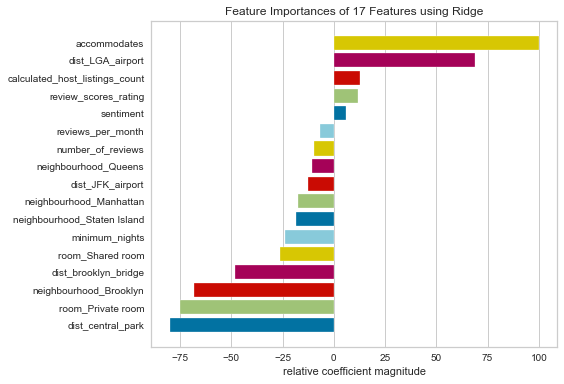

In [155]:
#plot feature importances
feature_importances(ridge, X_train, y_train);

Ridge regression coefficients are slightly harder to interpret, but we can still see the feature importance and the general effect each feature has on price (positive/negative). Here we see the most important feature is `accommodates`, which leads to an increase in price, followed by `dist_central_park`. This means, holding all other features constant, an increase in the distance from Central Park leads to a decrease in the daily price of a listing. We can see some of the features which we thought were most important in the linear regression are no longer as important as they were before, indicating they have been penalised. 

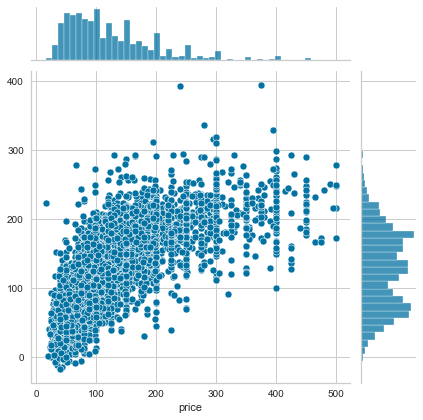

In [156]:
#plot actuals vs predicted values - looks slightly better than before but still not great 
sns.jointplot(x=y_test,y=y_pred)

#### LASSO regression
We will try to use LASSO now to compare against Ridge Regression, as this will be harsher on redundant features and set them to 0 if they are not needed. 

In [157]:
#find the optimal alpha value for the penalty term 
optimal_lasso = LassoCV(n_alphas=500, cv=10, n_jobs=-1)
optimal_lasso.fit(Xs_train, y_train)

print(optimal_lasso.alpha_)

0.04260814083265882


In [158]:
# fit lasso using the optimal alpha and cross validate the scores on the train set 
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv=10, scoring='neg_mean_squared_error')

print('Fold RMSEs:')
print(np.sqrt(-lasso_scores))
print('===')
print('Average RMSE: {}'.format(np.mean(np.sqrt(-lasso_scores))))

print('STD of RMSE: {}'.format(np.std(np.sqrt(-lasso_scores))))

Fold RMSEs:
[55.70402301 59.16321873 53.46936148 52.29513076 56.27202776 58.3918543
 51.89030871 54.56939845 53.33382749 50.77502384]
===
Average RMSE: 54.586417451784165
STD of RMSE: 2.6340384861812294


In [159]:
# Fit the model.
lasso.fit(Xs_train, y_train)

# Predict with fitted model.
y_pred = lasso.predict(Xs_test)
print("Test RMSE using optimal alpha: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Test RMSE using optimal alpha:  54.02286784275697


Using LASSO hasn't made a huge difference on the test RMSE in comparison to Ridge Regression. Maybe we do need all our features! 

C:\Users\hmalek\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


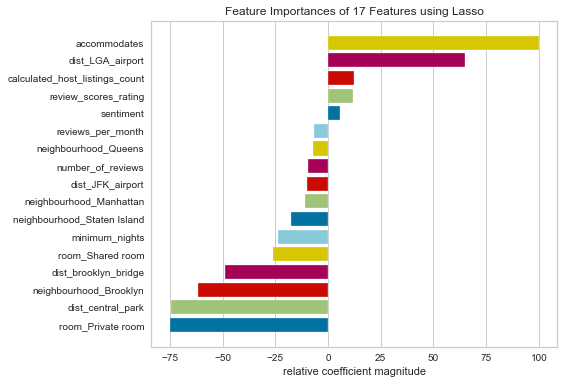

In [160]:
#plot feature importances - slightly similar to what we saw before. 
feature_importances(lasso, X_train, y_train);

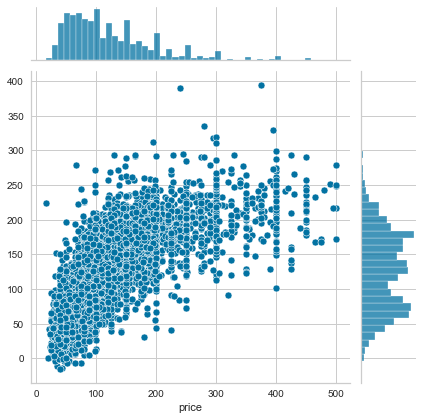

In [161]:
#plot actuals vs predicted values, looks similar to ridge predictions
sns.jointplot(x=y_test,y=y_pred)

### Decision Tree Regressor

We will now try predicting price using a decision tree regressor and see whether this gives us better predictions. Decision Trees are non-parametric models which don't assume normality or a linear relationship between the features and response variable, and so it might perform better on our non-linear data. 

In [162]:
#select feature cols 
feature_cols = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'neighbourhood_Brooklyn', 
               'neighbourhood_Manhattan', 'neighbourhood_Queens', 'neighbourhood_Staten Island', 'room_Private room',
                'room_Shared room', 'sentiment', 'dist_central_park', 'dist_brooklyn_bridge', 'dist_LGA_airport', 
                'dist_JFK_airport', 'accommodates', 'review_scores_rating']

In [163]:
X = listings_data_cheap[feature_cols]
y = listings_data_cheap.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 99)
#use same random state to keep the same test group as above

In [164]:
X.head()

minimum_nights  number_of_reviews  reviews_per_month  \
0               1                 45               0.38   
1               1                270               4.64   
2               2                430               3.47   
3               2                118               0.99   
4               4                167               1.34   

   calculated_host_listings_count  neighbourhood_Brooklyn  \
0                               2                       0   
1                               1                       1   
2                               1                       0   
3                               1                       0   
4                               3                       1   

   neighbourhood_Manhattan  neighbourhood_Queens  neighbourhood_Staten Island  \
0                        1                     0                            0   
1                        0                     0                            0   
2                        1                     0                            0   
3                        1                     0                            0   
4                        0                     0                            0   

   room_Private room  room_Shared room  sentiment  dist_central_park  \
0                  0                 0   0.337270           3.734490   
1                  0                 0   0.355942          11.137231   
2                  1                 0   0.289852           2.647665   
3                  1                 0   0.428167           1.857856   
4                  1                 0   0.407715          13.091268   

   dist_brooklyn_bridge  dist_LGA_airport  dist_JFK_airport  accommodates  \
0              5.411107          9.521023         20.900116             2   
1              3.903672         12.486584         15.652253             3   
2              6.626684          9.348626         21.729521             2   
3             10.941406          8.216218         23.456955             1   
4              4.264603         15.398688         17.547135             2   

   review_scores_rating  
0                  94.0  
1                  89.0  
2                  84.0  
3                  98.0  
4                  94.0

In [165]:
print(X_train.shape)
print(X_test.shape)

(12856, 17)
(5511, 17)


First we will use cross validation to find the optimal tree depth by looking for the number of levels that result in the lowest RMSE. 

In [166]:
# Tuning the tree

# List of values to try between 1 and the max features we have:
max_depth_range = list(range(1, 18))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use 10 fold CV with each value of max_depth. Train the model each time on the train set only 
#as I don't want to leak information from the test group 
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

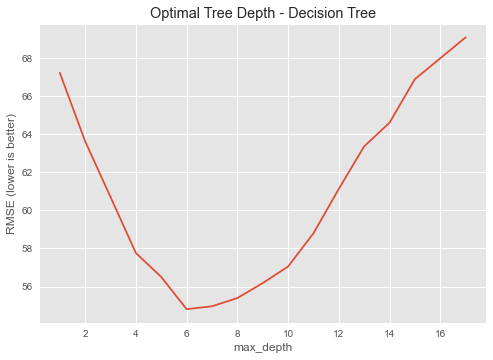

In [167]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.style.use('ggplot')
plt.plot(max_depth_range, RMSE_scores)
plt.title("Optimal Tree Depth - Decision Tree")
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

Here we can see using 6 levels is probably best

In [168]:
#Lowest RMSE using 6 levels
treereg = DecisionTreeRegressor(random_state=1, max_depth=6)

In [169]:
#fit the tree
treereg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, random_state=1)

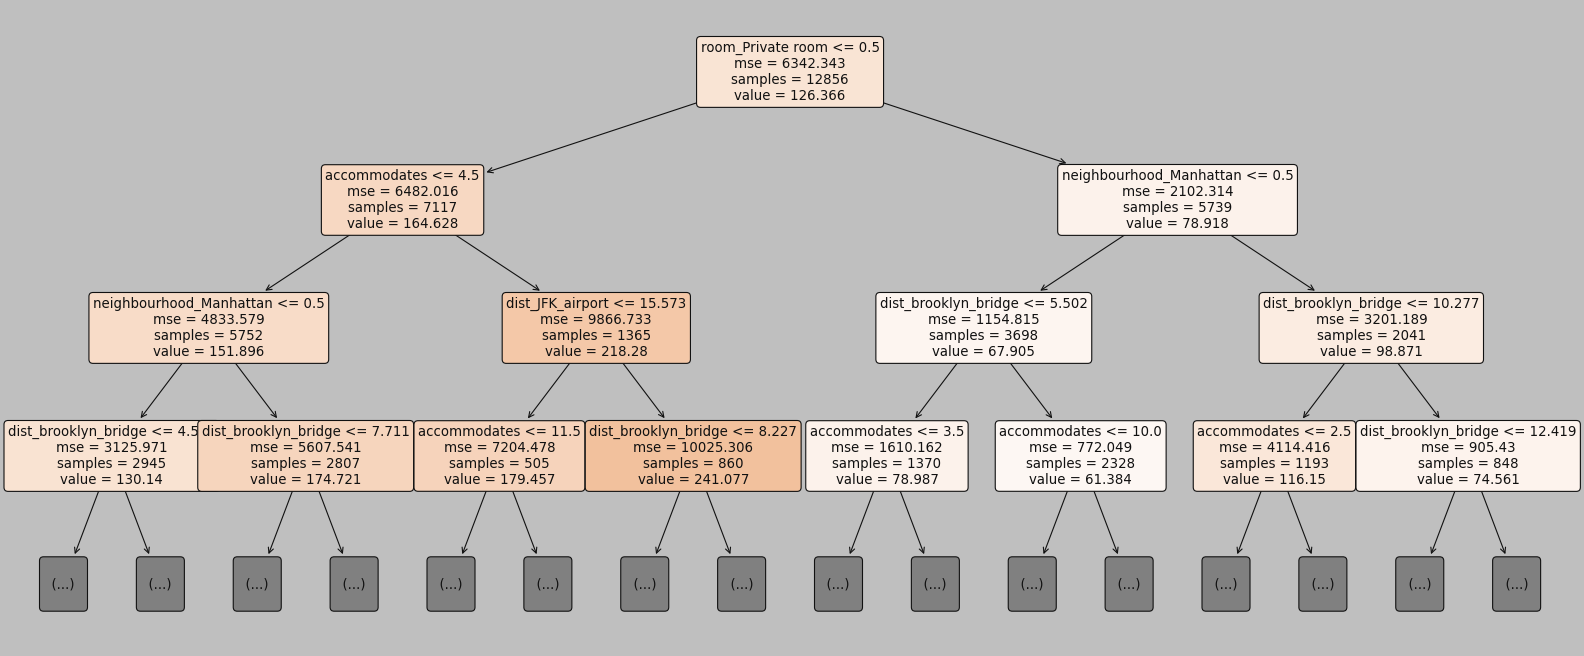

In [170]:
# plot the first 3 levels of the tree - hard to visualise the full thing
plt.style.use('classic')
fig, ax = plt.subplots(1,1, figsize=(25,10)) 
plot_tree(treereg, feature_names=feature_cols, fontsize=12, filled=True, rounded=True, max_depth=3);


It's difficult to tell what the full output of the tree looks like, but we can see how this model performs on the test set and then look at feature importances to get an idea of the most important features.  

In [171]:
#cross validate the train RMSE and get the average using 10 fold CV
train_scores = cross_val_score(treereg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# print the scores and average 
print(np.sqrt(-train_scores))
print("Average train RMSE: ", np.mean(np.sqrt(-train_scores)))

[56.8110244  57.69903459 54.18043022 51.66560576 57.01765085 57.54548276
 54.49566979 53.94829869 54.27105197 50.49534883]
Average train RMSE:  54.81295978435425


In [172]:
# Use fitted model to make predictions on testing data.
y_pred = treereg.predict(X_test)

In [173]:
print("RMSE Test set: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#Baseline RMSE
print("Baseline RMSE: ", np.sqrt(metrics.mean_squared_error(y, np.repeat(np.mean(y),len(y)))))

RMSE Test set:  53.04564168364313
Baseline RMSE:  79.48252574715806


Our RMSE on the test set predictions is similar to our cross validated train set RMSE. Our test RMSE using a decision tree is  slightly better than the linear regression RMSE and is still better than the baseline RMSE. The test RMSE is also better than we saw in the previous models. 

In [174]:
#Importance of each feature
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

feature  importance
0                   minimum_nights    0.004918
1                number_of_reviews    0.004805
2                reviews_per_month    0.002047
3   calculated_host_listings_count    0.011792
4           neighbourhood_Brooklyn    0.000000
5          neighbourhood_Manhattan    0.087801
6             neighbourhood_Queens    0.000000
7      neighbourhood_Staten Island    0.000000
8                room_Private room    0.497697
9                 room_Shared room    0.021176
10                       sentiment    0.004534
11               dist_central_park    0.018880
12            dist_brooklyn_bridge    0.109121
13                dist_LGA_airport    0.005295
14                dist_JFK_airport    0.036642
15                    accommodates    0.193772
16            review_scores_rating    0.001520

Text(0.5, 1.0, 'Feature Importance - Decision Tree')

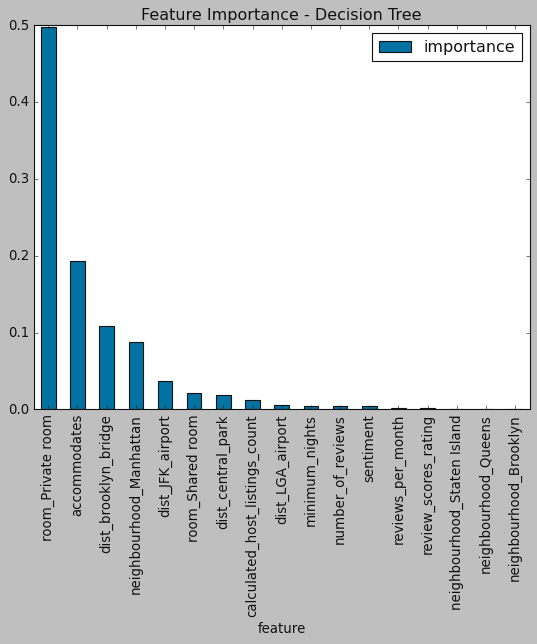

In [175]:
#plot feature importances 
feature_importance = pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})
feature_importance.sort_values(by='importance', ascending = False).plot(x='feature', y = 'importance', kind='bar')
plt.title('Feature Importance - Decision Tree')

Here we can see `room_Private_room` is the most important feature, followed by `accommodates` and `dist_brooklyn_bridge`. This is similar to what we saw in our previous model. 

### Random Forest

While decision trees are highly explanatory, they can easily be overfit and different variations in the train data can also lead to very different trees. To enhance this, we will build a Random Forest, which builds multiple trees on subsets of the data and takes the average value for the predictions. 

#### Tuning the tree 
First we will fit lots of models with different parameters to find which gives the lowest RMSE, and then use these parameters to fit our final Random Forest and evaluate its performance on the test data

In [176]:
# List of values to try for n_estimators:
estimator_range = list(range(5, 205, 10))

# List to store the average RMSE for each value of n_estimators:
RMSE_scores = []

# Use five-fold cross-validation with each value of n_estimators (Warning: Slow!).
# fit each time on our train set so we don't leak any information from the test set 
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

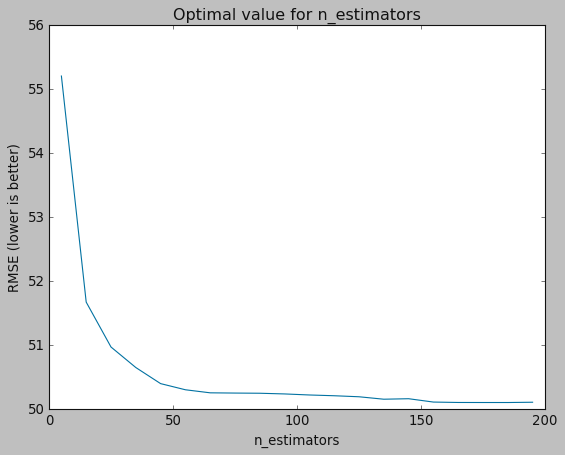

In [177]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).
plt.plot(estimator_range, RMSE_scores);
plt.title("Optimal value for n_estimators")
plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

In [178]:
# Show the best RMSE and the corresponding max_depth.
sorted(zip(RMSE_scores, estimator_range))[0]

(50.09909696011417, 185)

Looks like 185 is the optimal value to use for `n_estimators`

In [179]:
# Use this optimal estimator value to find the optimal max_features:
feature_range = list(range(1, len(feature_cols)+1))

# List to store the average RMSE for each value of max_features:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_features (Warning: Super slow!).
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=185, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Text(0.5, 1.0, 'Optimal value for max_features')

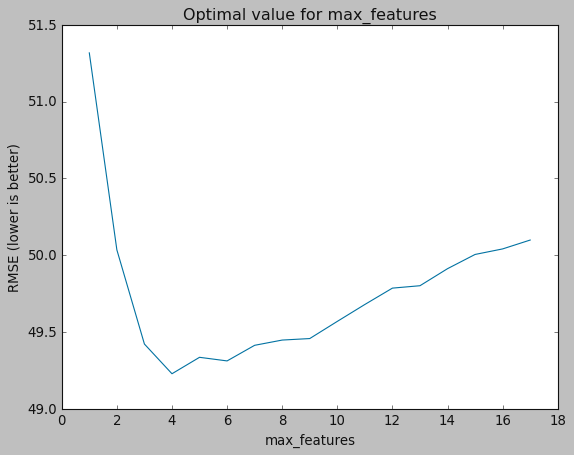

In [180]:
# Plot max_features (x-axis) versus RMSE (y-axis).

plt.plot(feature_range, RMSE_scores);

plt.xlabel('max_features');
plt.ylabel('RMSE (lower is better)');
plt.title("Optimal value for max_features")

This shows the optimal value of `max_features` is 4 

In [181]:
# Show the best RMSE and the corresponding max_depth.
sorted(zip(RMSE_scores, feature_range))[0]

(49.22864378485341, 4)

Now, using these two parameters, we can fit our random forest model and use it to perform predictions and evaluate its performance. 

In [182]:
# max_features=4 is best and n_estimators=185 is best
rfreg = RandomForestRegressor(n_estimators=185, 
                              max_features=4, 
                              oob_score=True, 
                              random_state=1)
rfreg.fit(X_train, y_train)

RandomForestRegressor(max_features=4, n_estimators=185, oob_score=True,
                      random_state=1)

In [183]:
# Compute the out-of-bag RMSE.
print('OOB RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, rfreg.oob_prediction_))))

OOB RMSE: 49.457992036406864


In [184]:
# Find the average train RMSE with CV to compare against the other models.
scores = cross_val_score(rfreg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print(np.sqrt(-scores))
print('Average CV train RMSE: {}'.format(np.mean(np.sqrt(-scores))))

[50.13610504 51.58219777 49.11181728 46.12395297 52.07117954 52.67664254
 47.71468018 49.60362052 48.86825951 46.34302576]
Average CV train RMSE: 49.423148112127066


In [185]:
#predict on test set and evaluate model performance 
y_pred = rfreg.predict(X_test)
print("RMSE Test set: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#Baseline RMSE
print("Baseline RMSE: ", np.sqrt(metrics.mean_squared_error(y, np.repeat(np.mean(y),len(y)))))

RMSE Test set:  48.77094965787872
Baseline RMSE:  79.48252574715806


The test RMSE is similar again to our cross-validated train RMSE, which shows we haven't overfitted. Also, the Random Forest model seems to perform the best out of all the models we have built so far due to its lowest RMSE on the test dataset. 

In [186]:
# Compute feature importances.
pd.DataFrame({'feature':feature_cols, 
              'importance':rfreg.feature_importances_}).sort_values(by='importance', ascending=False)

feature  importance
15                    accommodates    0.191411
8                room_Private room    0.185482
12            dist_brooklyn_bridge    0.101471
14                dist_JFK_airport    0.093365
11               dist_central_park    0.076720
13                dist_LGA_airport    0.067397
10                       sentiment    0.056498
2                reviews_per_month    0.047245
1                number_of_reviews    0.039254
16            review_scores_rating    0.033537
0                   minimum_nights    0.031789
3   calculated_host_listings_count    0.027405
5          neighbourhood_Manhattan    0.026133
9                 room_Shared room    0.012002
4           neighbourhood_Brooklyn    0.005499
6             neighbourhood_Queens    0.004518
7      neighbourhood_Staten Island    0.000275

Text(0.5, 1.0, 'Feature Importance - Random Forest')

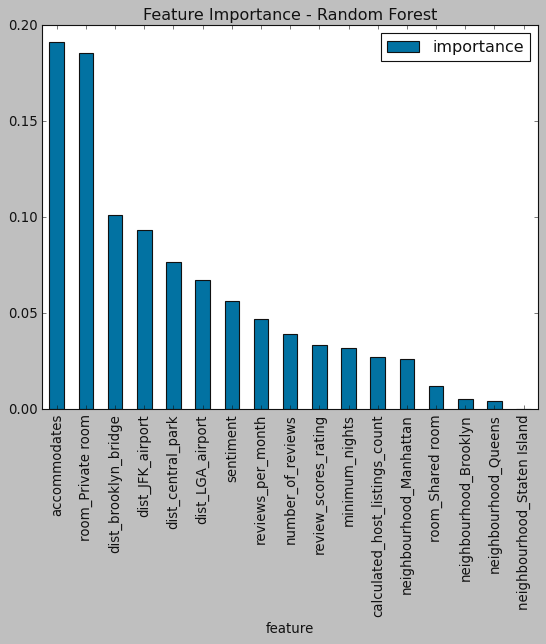

In [187]:
#plot feature importances 
feature_importance = pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_})
feature_importance.sort_values(by='importance', ascending = False).plot(x='feature', y = 'importance', kind='bar')
plt.title('Feature Importance - Random Forest')

This model is suggesting the most important feature to be `accommodates`, followed by `room_private_room` and `dist_Broooklyn_bridge`. These three were similar to what we saw in the Decision Tree regressor. 

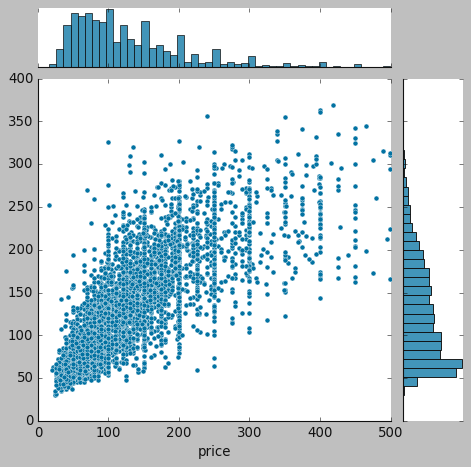

In [188]:
#plot predicted values against actual values 
sns.jointplot(x=y_test,y=y_pred);

We can calculate the Permutation Importances which are computed on the held-out test set (feature importances are calculated on the train set and may not reflect the ability of the feature's ability in making predictions that generalise well to a test set). This also shows that `accommodates` is the most important feature, followed by `room_Private_room` and `dist_brooklyn_bridge`.

In [189]:
from sklearn.inspection import permutation_importance

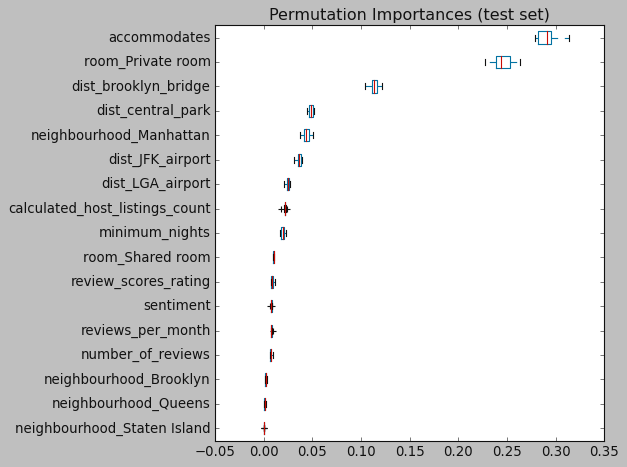

In [190]:
#plot permutation importances on test set and compare against train permutation importances 
result = permutation_importance(rfreg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

We can also compute the permutation importances on the train set and compare the two. Below we can see the permutation importances for each of the features is generally higher than it was in the test set, which shows the model may be prone to overfitting using these features. We can also see that in the test set above, many more of our features show close to 0 importance in comparison to the train set. We could try removing some of these features and re-fitting the model to evaluate its performance using features we think are most important only.  

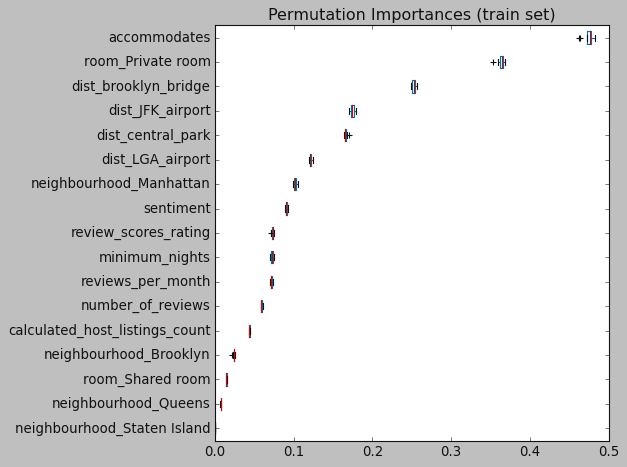

In [191]:
#plot permutation importances on train set 
result = permutation_importance(rfreg, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

I will use `SelectFromModel` to select features with the most importance and train a new model to evaluate the difference in performance against the model with all the features. 

In [192]:
# Create a selector object that will use the random forest regressor to identify
# features that have an importance of more than 0.01

from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(rfreg, threshold=0.01)

# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(max_features=4,
                                                n_estimators=185,
                                                oob_score=True,
                                                random_state=1),
                threshold=0.01)

In [193]:
#get a list of features we will use in the new model 
for feature_list_index in sfm.get_support(indices=True):
    print(feature_cols[feature_list_index])

minimum_nights
number_of_reviews
reviews_per_month
calculated_host_listings_count
neighbourhood_Manhattan
room_Private room
room_Shared room
sentiment
dist_central_park
dist_brooklyn_bridge
dist_LGA_airport
dist_JFK_airport
accommodates
review_scores_rating


It looks like we have removed 3 features that were least important to our model

In [194]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [195]:
#build the random forest using only the selected features
rf_important = RandomForestRegressor(n_estimators=185, 
                              max_features=4, 
                              oob_score=True, 
                              random_state=1)
rf_important.fit(X_important_train, y_train)

RandomForestRegressor(max_features=4, n_estimators=185, oob_score=True,
                      random_state=1)

In [196]:
# Find the average train RMSE with CV to compare against the other models.
scores = cross_val_score(rf_important, X_important_train, y_train, cv=10, scoring='neg_mean_squared_error')
print(np.sqrt(-scores))
print('Average CV train RMSE: {}'.format(np.mean(np.sqrt(-scores))))

[49.81552109 51.61687796 48.9974707  45.7816085  52.0858664  52.82863312
 47.36916879 49.67133773 48.82612221 46.27373   ]
Average CV train RMSE: 49.32663364994372


In [197]:
#predict on test set and evaluate model performance 
y_pred = rf_important.predict(X_important_test)
print("RMSE Test set: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#Baseline RMSE
print("Baseline RMSE: ", np.sqrt(metrics.mean_squared_error(y, np.repeat(np.mean(y),len(y)))))

RMSE Test set:  48.80172439742247
Baseline RMSE:  79.48252574715806


Removing the features with lowest feature importance has increased our RMSE very slightly. Although there is that small increase in RMSE, it is reassuring to know removing these two features hasn't decreased the model performance drastically. Since we didn't have a huge amount of features to start off with, removing 3 doesn't make a significant difference to the running speed, however this method would be useful if we had many features and wanted to reduce our run-time by only taking the most important ones. 

Looking at the remaining features, it looks as though the model still uses the average `sentiment` of reviews, as well as the number of reviews. If this model was to be used to predict what the price should be of a new property, we wouldn't have this information to feed into the model and so we would need to consider enhancing the model using only features available at the time. We can also see in the Permutation Importance plots that `sentiment` is less important to the test set than it appeared to be in the train set (along with the other review-related columns). It's possible we could build a model with similar test RMSE without these features. 

However, overall, when comparing against the other models we have built, the Random Forest outperforms all of them when evaluating RMSE. 

We could probably enhance the model further, as an RMSE of ~49 still isn't the best. It means on average, our predicted prices will be `$49` off the actual price, which may not be a huge issue for the expensive listings, but isn't great for cheaper rentals. We could probably take into account things like time of year (peak/off-peak times, weekends vs weekdays) as prices will fluctuate over time, and hosts may also increase their price on last minute bookings. We could also use the amenties listed in the detailed listings data and create features like `has_wifi`, `has_elevator`, `has_AC`, `free_parking`, as I'm sure some of these will also be indicative of price. 

In [198]:
#need to look into how to change values within lists into dummies 
listings_data.amenities[1].split(",")

['["Hot water"',
 ' "Shampoo"',
 ' "Baby safety gates"',
 ' "Oven"',
 ' "Extra pillows and blankets"',
 ' "Pack \\u2019n Play/travel crib"',
 ' "Iron"',
 ' "Long term stays allowed"',
 ' "TV"',
 ' "Wifi"',
 ' "Refrigerator"',
 ' "Dedicated workspace"',
 ' "Air conditioning"',
 ' "Free parking on premises"',
 ' "Lockbox"',
 ' "Children\\u2019s books and toys"',
 ' "Free street parking"',
 ' "Smoke alarm"',
 ' "Bathtub"',
 ' "Heating"',
 ' "Dishes and silverware"',
 ' "Fire extinguisher"',
 ' "Essentials"',
 ' "Microwave"',
 ' "Bed linens"',
 ' "High chair"',
 ' "Hair dryer"',
 ' "Coffee maker"',
 ' "Cooking basics"',
 ' "Cable TV"',
 ' "Luggage dropoff allowed"',
 ' "Stove"',
 ' "Hangers"',
 ' "Kitchen"',
 ' "Carbon monoxide alarm"]']

### (Additional work) Rental names analysis
We can do some analysis on the popular words used in rental names in NYC to see whether there are any that appear more often than others 

In [199]:
listings_data_cheap.head()

id                                            name host_id    host_name  \
0  2595                           Skylit Midtown Castle    2845     Jennifer   
1  3831                 Cozy Entire Floor of Brownstone    4869  LisaRoxanne   
2  5178                Large Furnished Room Near B'way     8967     Shunichi   
3  5203              Cozy Clean Guest Room - Family Apt    7490    MaryEllen   
4  5803  Lovely Room 1, Garden, Best Area, Legal rental    9744       Laurie   

  neighbourhood_group    neighbourhood  latitude  longitude        room_type  \
0           Manhattan          Midtown  40.75362  -73.98377  Entire home/apt   
1            Brooklyn     Clinton Hill  40.68514  -73.95976  Entire home/apt   
2           Manhattan   Hell's Kitchen  40.76489  -73.98493     Private room   
3           Manhattan  Upper West Side  40.80178  -73.96723     Private room   
4            Brooklyn      South Slope  40.66829  -73.98779     Private room   

   price  ...  neighbourhood_Manhattan  neighbourhood_Queens  \
0    225  ...                        1                     0   
1     89  ...                        0                     0   
2     79  ...                        1                     0   
3     79  ...                        1                     0   
4     89  ...                        0                     0   

  neighbourhood_Staten Island  room_Private room  room_Shared room  \
0                           0                  0                 0   
1                           0                  0                 0   
2                           0                  1                 0   
3                           0                  1                 0   
4                           0                  1                 0   

   dist_central_park  dist_brooklyn_bridge  dist_LGA_airport dist_JFK_airport  \
0           3.734490              5.411107          9.521023        20.900116   
1          11.137231              3.903672         12.486584        15.652253   
2           2.647665              6.626684          9.348626        21.729521   
3           1.857856             10.941406          8.216218        23.456955   
4          13.091268              4.264603         15.398688        17.547135   

  dist_statue_liberty  
0            8.799501  
1            7.159761  
2            9.795228  
3           14.105066  
4            5.319920  

[5 rows x 37 columns]

The below function will process any text by firstly keeping letters only (removing punctuation), converting everything to lower case and splitting sentences into words and then removing stopwords and converting words to their stemmed version. 
Here I also add some additional frequently used words in the stop words list such as NYC, Manhattan, Apartment and Room. 

In [200]:

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
stop_words = stopwords.words('english')
custom_stop_words = ['brooklyn', 'manhattan', 'nyc', 'apartment', 'room', 'bedroom', 'studio', 'apt']
stop_words.extend(custom_stop_words)

def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split into words
    words = letters_only_text.lower().split()

    cleaned_words = []
    lemmatizer = PorterStemmer() 
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # stemm or lemmatise words
    stemmed_words = []
    for word in cleaned_words:
        word = lemmatizer.stem(word)   
        stemmed_words.append(word)
    
    # converting list back to string
    return " ".join(stemmed_words)

In [201]:
#apply function to our dataset and add a new column with the processed version of text 
listings_data_cheap['prep'] = listings_data_cheap[listings_data_cheap.name.notnull()]['name'].apply(preprocess)

C:\Users\hmalek\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [202]:
listings_data_cheap.head()

id                                            name host_id    host_name  \
0  2595                           Skylit Midtown Castle    2845     Jennifer   
1  3831                 Cozy Entire Floor of Brownstone    4869  LisaRoxanne   
2  5178                Large Furnished Room Near B'way     8967     Shunichi   
3  5203              Cozy Clean Guest Room - Family Apt    7490    MaryEllen   
4  5803  Lovely Room 1, Garden, Best Area, Legal rental    9744       Laurie   

  neighbourhood_group    neighbourhood  latitude  longitude        room_type  \
0           Manhattan          Midtown  40.75362  -73.98377  Entire home/apt   
1            Brooklyn     Clinton Hill  40.68514  -73.95976  Entire home/apt   
2           Manhattan   Hell's Kitchen  40.76489  -73.98493     Private room   
3           Manhattan  Upper West Side  40.80178  -73.96723     Private room   
4            Brooklyn      South Slope  40.66829  -73.98779     Private room   

   price  ...  neighbourhood_Queens  neighbourhood_Staten Island  \
0    225  ...                     0                            0   
1     89  ...                     0                            0   
2     79  ...                     0                            0   
3     79  ...                     0                            0   
4     89  ...                     0                            0   

  room_Private room  room_Shared room  dist_central_park  \
0                 0                 0           3.734490   
1                 0                 0          11.137231   
2                 1                 0           2.647665   
3                 1                 0           1.857856   
4                 1                 0          13.091268   

   dist_brooklyn_bridge  dist_LGA_airport  dist_JFK_airport  \
0              5.411107          9.521023         20.900116   
1              3.903672         12.486584         15.652253   
2              6.626684          9.348626         21.729521   
3             10.941406          8.216218         23.456955   
4              4.264603         15.398688         17.547135   

  dist_statue_liberty                                prep  
0            8.799501                skylit midtown castl  
1            7.159761          cozi entir floor brownston  
2            9.795228             larg furnish near b way  
3           14.105066             cozi clean guest famili  
4            5.319920  love garden best area legal rental  

[5 rows x 38 columns]

In [203]:
#remove listings with no name 
listings_data_cheap_clean = listings_data_cheap[listings_data_cheap.name.notnull()]

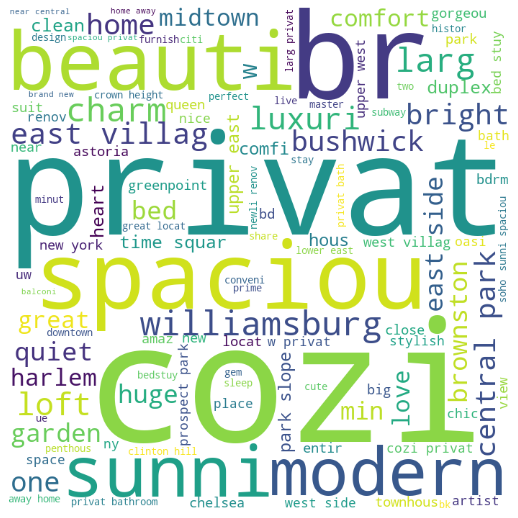

In [204]:
# generate wordcloud of popular words used in listing names
from wordcloud import WordCloud

%matplotlib inline

all_words = '' 

#looping through all incidents and joining them to one text, to extract most common words
for arg in listings_data_cheap_clean["prep"]: 

    tokens = arg.split()  
      
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='white',
                min_font_size = 10).generate(all_words) 


# plot the WordCloud image                        
plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Here we can also see the usage of common words like 'modern', 'luxury', 'beautiful', 'spacious', 'cozy', 'private. We can take a count of each word's occurrence and see which are the most popular words. 

<AxesSubplot:>

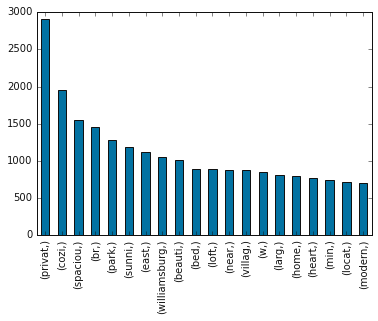

In [205]:
# form 1-grams to visualise most common words
from nltk.util import ngrams
(pd.Series(ngrams(all_words.split(), 1)).value_counts())[:20].plot(kind = 'bar')

It looks like 'private' is the most common word used in rental names, followed by cozy and spacious. 

We can also have a look at the most common n-grams; below we look at the most common bi-grams. We see that the most common bi-grams are mostly area names like East Village, Central Park and East Side, as well as some that reflect the property description or amenities like 'great location' or 'private bath'. 

<AxesSubplot:>

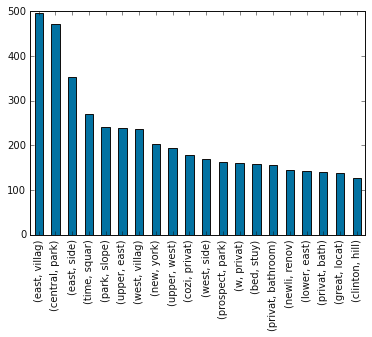

In [206]:
from nltk.util import ngrams
(pd.Series(ngrams(all_words.split(), 2)).value_counts())[:20].plot(kind = 'bar')

Looking at 3-grams, we can see again that the most common ones are based on location. We see a common usage of 'home away home' which is possibly 'home away from home' 

<AxesSubplot:>

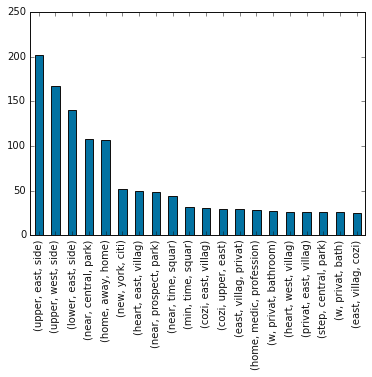

In [207]:
(pd.Series(ngrams(all_words.split(), 3)).value_counts())[:20].plot(kind = 'bar')